# Modeling

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score

# Hyperparameters Tuning

In [2]:
def plot_cluster_counts(labels, title, post_title='', color='viridis'):
    plt.figure(figsize=(6, 3))
    sns.countplot(x=labels, palette=color, hue=labels)
    plt.xlabel('Cluster Index')
    plt.ylabel('Number of Data Points')
    plt.title(f"{title} Counts {post_title}")
    plt.show()

def plot_scatter_clusters(X, labels, title, components = (0, 1), color='viridis'):
    plt.figure(figsize=(8, 4))
    plt.scatter(X[components[0]], X[components[1]], c=labels, cmap=color, s=10)
    plt.title(f"{title} (PCA Reduced)")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.colorbar(label='Cluster Label')
    plt.show()

def plot_3d_scatter_clusters(X, labels, title, components = (0, 1, 2), color='viridis'):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[components[0]], X[components[1]], X[components[2]], c=labels, cmap=color, s=50)
    ax.set_title(f"{title} in 3D (PCA Reduced)")
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    plt.show()

def plot_heatmap(results_df, score_title='F1-score'):
    plt.figure(figsize=(8, 5))
    sns.heatmap(results_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"Classifier {score_title}")
    plt.ylabel("Clustering Algorithm")
    plt.xlabel("Classifier")
    plt.show()

## Data Preprocessing

In [3]:
aligned_unscaled = pd.read_parquet('clean/aligned_unscaled.parquet')
aligned_unscaled.drop(columns=['query_ts', 'transaction_id'], inplace=True)

train_size = int(len(aligned_unscaled) * 0.8)
train_df = aligned_unscaled.iloc[:train_size]
test_df = aligned_unscaled.iloc[train_size:]
train_df.shape, test_df.shape

((247741, 287), (61936, 287))

In [15]:
preprocessing = Pipeline([
    ('minmax', MinMaxScaler()),
    # ('robust', RobustScaler()),
    ('pca', PCA(n_components=0.95))
])

X_preprocessed = preprocessing.fit_transform(train_df)
X_preprocessed_test = preprocessing.transform(test_df)
# pd.DataFrame(X_preprocessed).to_parquet('clean/X_preprocessed_train.parquet', compression='gzip')
X_preprocessed.shape, X_preprocessed_test.shape

(248687, 18)

In [5]:
X_scaled = MinMaxScaler().fit_transform(train_df)
X_pca = preprocessing.named_steps['pca'].fit_transform(X_scaled)

X_reconstructed = preprocessing.named_steps['pca'].inverse_transform(X_pca)
print(X_reconstructed.shape)

reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2)
print(f"Reconstruction MSE: {reconstruction_error:.4f}")

(247741, 287)
Reconstruction MSE: 0.0011


### Data Preprocessing New Features

In [11]:
aligned_unscaled = pd.read_parquet('clean/prepared_with_features_2.parquet')
aligned_unscaled.reset_index(drop=True, inplace=True)

train_size = int(len(aligned_unscaled) * 0.8)
train_df = aligned_unscaled.iloc[:train_size]
test_df = aligned_unscaled.iloc[train_size:]
train_df.shape, test_df.shape

((248687, 100), (62172, 100))

In [17]:
aligned_unscaled.shape

(310859, 100)

In [19]:
preprocessing = Pipeline([
    ('robust', RobustScaler()),
    ('minmax', MinMaxScaler()),
    ('pca', PCA(n_components=0.95))
])

X_preprocessed = preprocessing.fit_transform(train_df)
X_preprocessed_test = preprocessing.transform(test_df)
# pd.DataFrame(X_preprocessed).to_parquet('clean/X_preprocessed_train_3.parquet', compression='gzip')
# pd.DataFrame(X_preprocessed_test).to_parquet('clean/X_preprocessed_test_3.parquet', compression='gzip')
X_preprocessed.shape, X_preprocessed_test.shape

((248687, 18), (62172, 18))

In [105]:
X_scaled_1 = preprocessing.named_steps['robust'].fit_transform(train_df)
X_scaled_2 = preprocessing.named_steps['minmax'].fit_transform(X_scaled_1)
X_pca = preprocessing.named_steps['pca'].fit_transform(X_scaled_2)

X_reconstructed = preprocessing.named_steps['pca'].inverse_transform(X_pca)
print(X_reconstructed.shape)

reconstruction_error = np.mean((X_scaled_2 - X_reconstructed) ** 2)
print(f"Reconstruction MSE: {reconstruction_error:.4f}")

(248687, 100)
Reconstruction MSE: 0.0007


Lower reconstruction error than for the data with new features (0.0007 vs 0.0011) means that the PCA model is able to capture more variance in the data, which is a good sign.

## KMeans Number of Clusters

In [ ]:
X_preprocessed = pd.read_parquet('clean/X_preprocessed_train.parquet')
X_preprocessed.shape

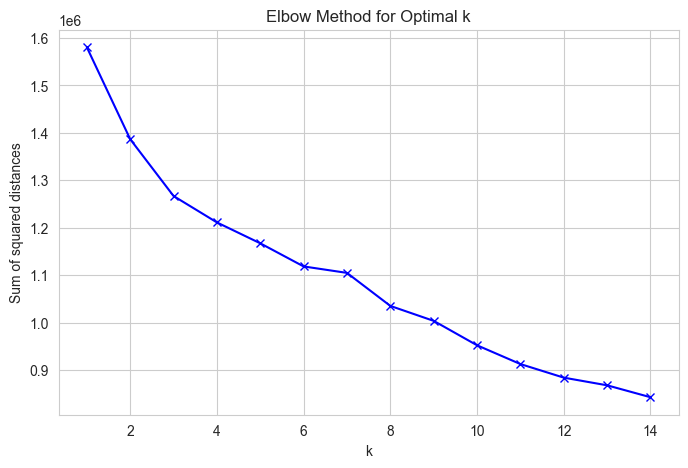

In [6]:
sum_of_squared_distances = []
K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_preprocessed)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

The graph shows that the optimal number of clusters is k=3 (or k=8).

In [3]:
train_sample = X_preprocessed[:20000]
train_sample.shape

(20000, 18)

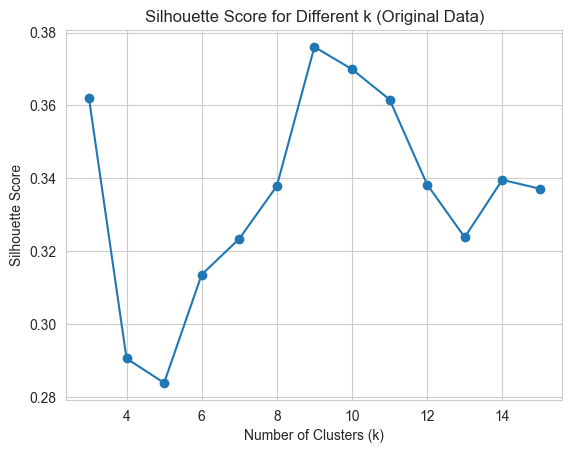

In [12]:
k_range = range(3, 16)
silhouette_scores_original = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(train_sample)
    labels = kmeans.labels_
    score = silhouette_score(train_sample, labels)
    silhouette_scores_original.append(score)

plt.plot(k_range, silhouette_scores_original, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k (Original Data)')
plt.show()

In [13]:
optimal_k = k_range[np.argmax(silhouette_scores_original)]
optimal_score = max(silhouette_scores_original)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Silhouette Score at optimal k: {optimal_score:.4f}")

Optimal number of clusters: 9
Silhouette Score at optimal k: 0.3761


Thought the highest silhouette score is at k=9, we can see that it is not significantly different from k=3.
The elbow method suggests that k=3 is a good choice, and it is also supported by the silhouette score.

In [29]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_results = kmeans.fit_predict(X_preprocessed)
kmeans_results.shape

(247741,)

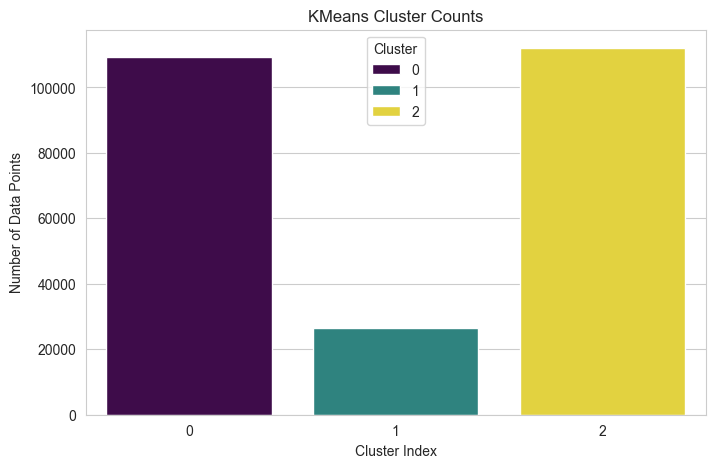

In [30]:
plot_cluster_counts(kmeans_results, "KMeans")

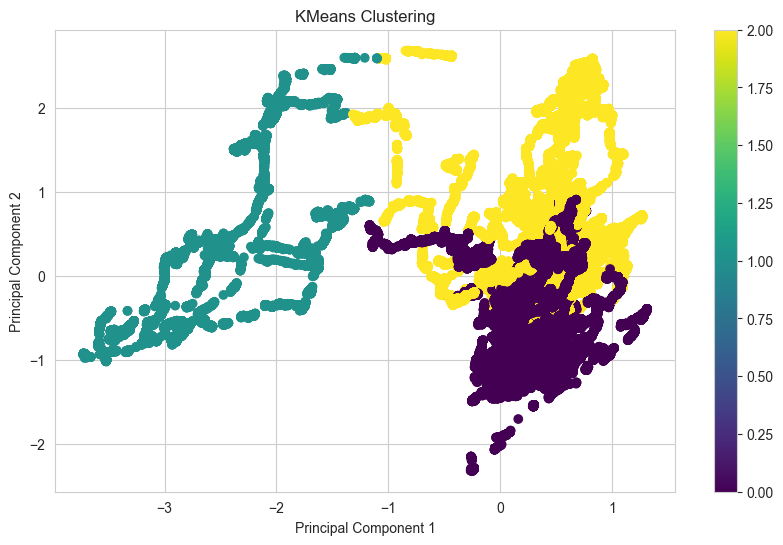

In [31]:
plot_scatter_clusters(X_preprocessed, kmeans_results, "KMeans")

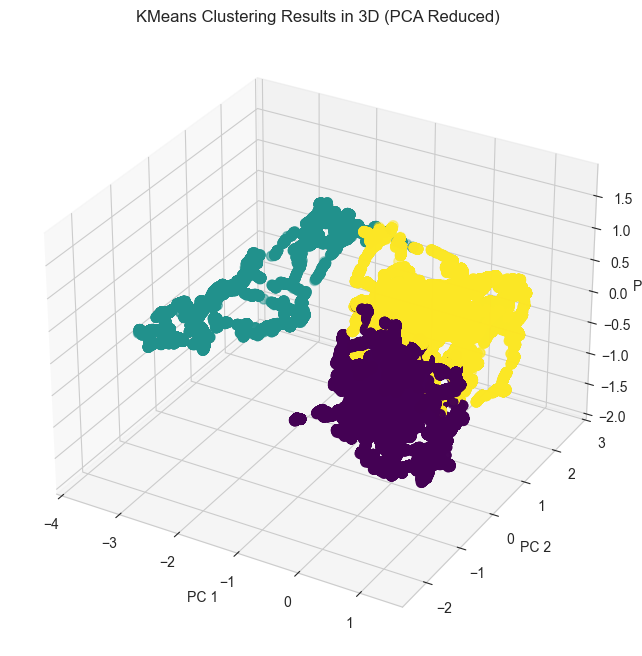

In [32]:
plot_3d_scatter_clusters(X_preprocessed, kmeans_results, "KMeans")

### Number of Clusters New Features

In [106]:
X_preprocessed = pd.read_parquet('clean/X_preprocessed_train_3.parquet')
train_sample = X_preprocessed[:100000]
X_preprocessed.shape, train_sample.shape

((248687, 18), (100000, 18))

In [106]:
train_sample = X_preprocessed[:50000]

In [ ]:
sum_of_squared_distances = []
silhouette_scores_original = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_sample)
    sum_of_squared_distances.append(kmeans.inertia_)
    labels = kmeans.labels_
    score = silhouette_score(train_sample, labels)
    silhouette_scores_original.append(score)

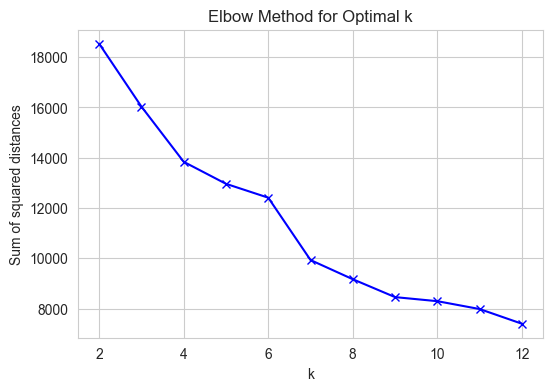

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

The graph shows that the optimal number of clusters is k=4.

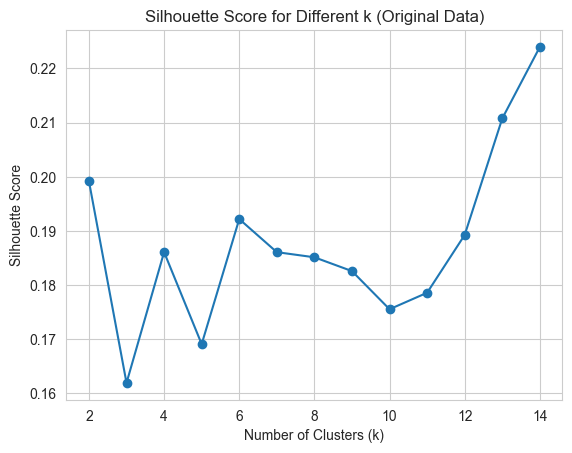

In [124]:
plt.plot(K, silhouette_scores_original, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k (Original Data)')
plt.show()

In [ ]:
optimal_k = k_range[np.argmax(silhouette_scores_original)]
optimal_score = max(silhouette_scores_original)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Silhouette Score at optimal k: {optimal_score:.4f}")

In [108]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_results = kmeans.fit_predict(X_preprocessed)
kmeans_results.shape

(248687,)

In [111]:
pd.DataFrame(kmeans_results).value_counts()

0
1    118004
2    100959
3     24324
0      5400
Name: count, dtype: int64

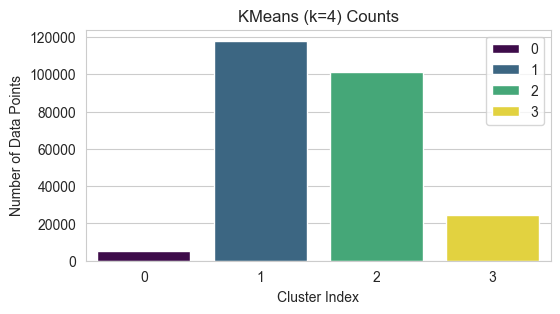

In [129]:
plot_cluster_counts(kmeans_results, f"KMeans (k={n_clusters})")

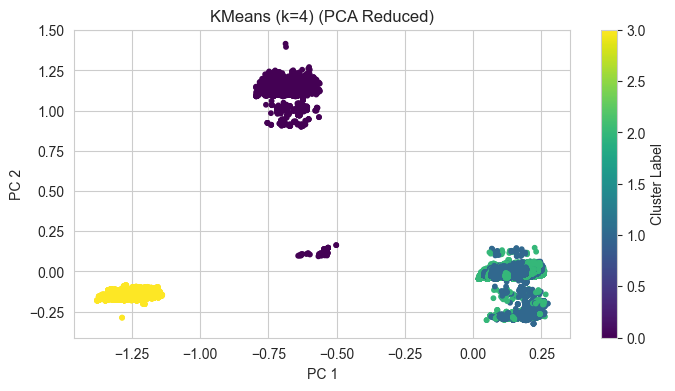

In [130]:
plot_scatter_clusters(X_preprocessed, kmeans_results, f"KMeans (k={n_clusters})", components=(0, 12))

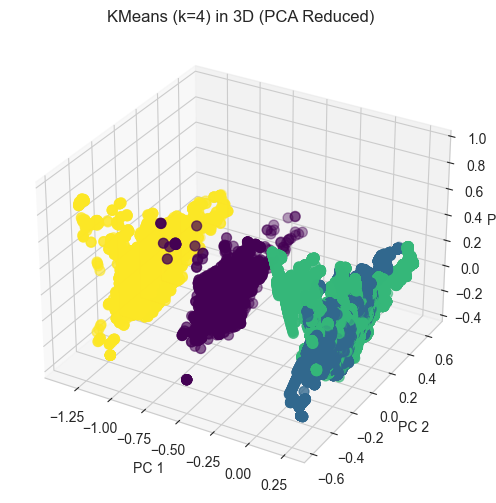

In [131]:
plot_3d_scatter_clusters(X_preprocessed, kmeans_results, f"KMeans (k={n_clusters})", components=(0, 13, 17))

In [132]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_results = kmeans.fit_predict(X_preprocessed)
kmeans_results.shape

(248687,)

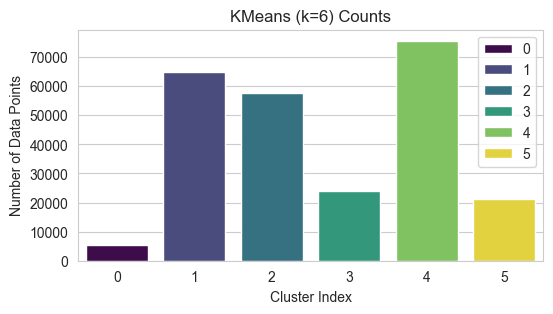

In [133]:
plot_cluster_counts(kmeans_results, f"KMeans (k={n_clusters})")

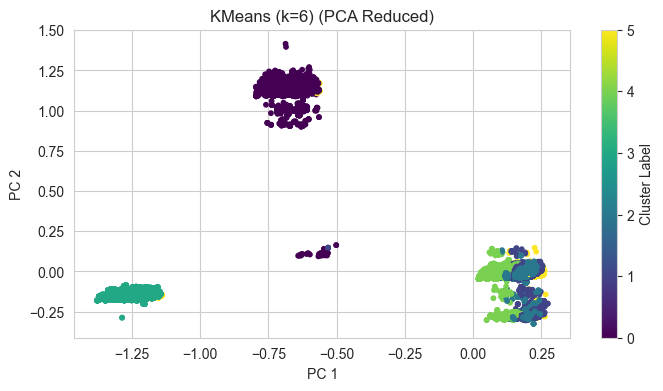

In [134]:
plot_scatter_clusters(X_preprocessed, kmeans_results, f"KMeans (k={n_clusters})", components=(0, 12))

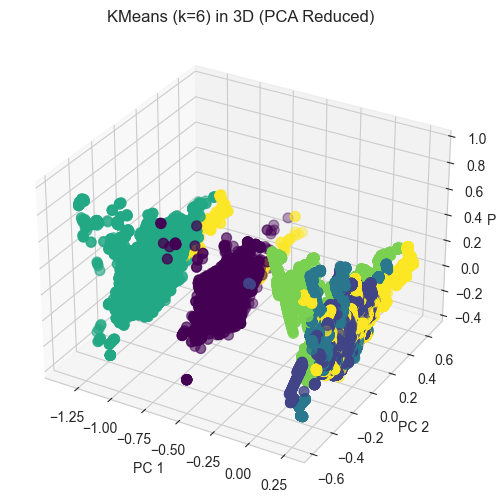

In [135]:
plot_3d_scatter_clusters(X_preprocessed, kmeans_results, f"KMeans (k={n_clusters})", components=(0, 13, 17))

The clusters are not well separated, and the silhouette score is low. The clusters for k=4 and k=6 look similar for the smallest cluster with outliers, so it is appropriate to choose simpler model with k=4.

## DBSCAN Distance Threshold

Distance threshold for DBSCAN and HDBSCAN can be determined using the k-distance plot. The idea is to plot the distance to the k-th nearest neighbor for each point in the dataset and look for a "knee" in the plot, which indicates a suitable value for eps.

In [2]:
X_preprocessed = pd.read_parquet('clean/X_preprocessed_train.parquet')
X_preprocessed.shape

(247741, 52)

In [ ]:
k = 52  # `min_samples` parameter - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_preprocessed)
distances, indices = neighbors_fit.kneighbors(X_preprocessed)
distances_k = distances[:, k - 1]
distances_k = np.sort(distances_k)

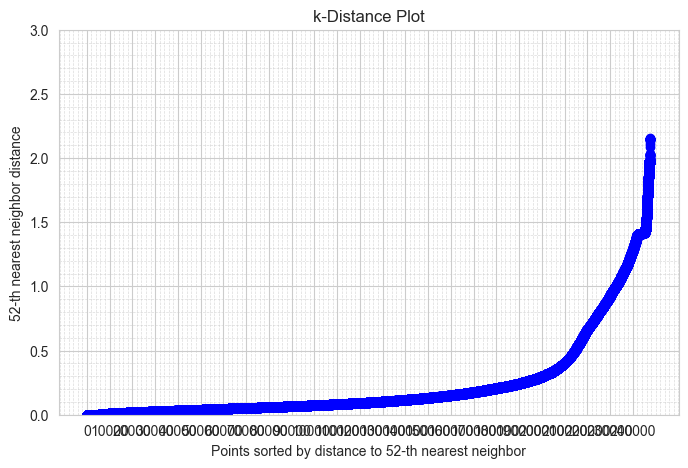

In [42]:
plt.figure(figsize=(8, 5))
plt.plot(distances_k, marker='o', linestyle='-', color='b')
plt.title('k-Distance Plot')
plt.ylim(0, 3)
plt.xticks(np.arange(0, len(distances_k), 10000))
plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(k))
plt.ylabel('{}-th nearest neighbor distance'.format(k))

plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)
plt.minorticks_on()
plt.show()

In [ ]:
dbscan = DBSCAN(eps=5, min_samples=53)
dbscan_result = dbscan.fit_predict(X_preprocessed)
dbscan_result = pd.DataFrame(dbscan_result, columns=['cluster'])

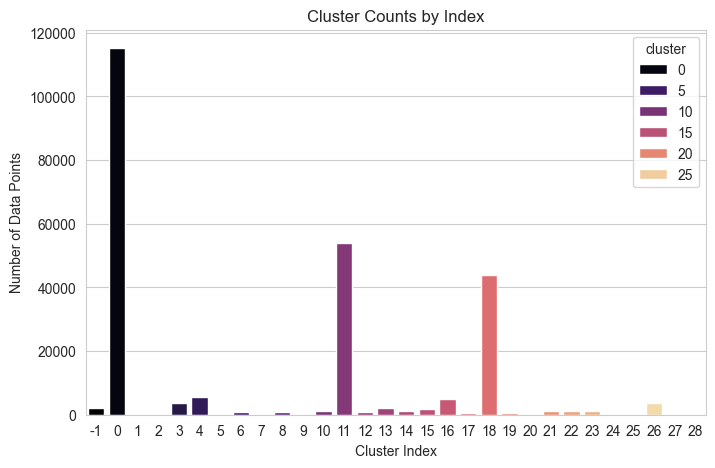

In [45]:
plot_cluster_counts(dbscan_result['cluster'], "DBSCAN", color='magma')

### Distance Threshold New Features

In [67]:
X_preprocessed = pd.read_parquet('clean/X_preprocessed_train_2.parquet')
X_preprocessed.shape

(248687, 18)

In [48]:
k = 100
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_preprocessed)
distances, indices = neighbors_fit.kneighbors(X_preprocessed)
distances_k = distances[:, k - 1]
distances_k = np.sort(distances_k)

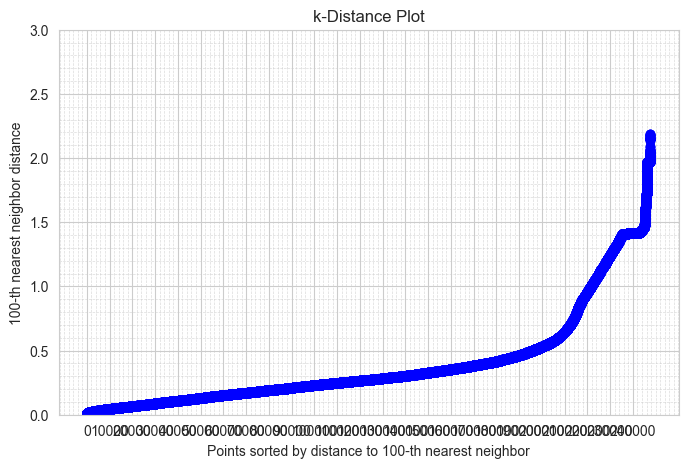

In [49]:
plt.figure(figsize=(8, 5))
plt.plot(distances_k, marker='o', linestyle='-', color='b')
plt.title('k-Distance Plot')
plt.ylim(0, 3)
plt.xticks(np.arange(0, len(distances_k), 10000))
plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(k))
plt.ylabel('{}-th nearest neighbor distance'.format(k))

plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)
plt.minorticks_on()
plt.show()

In [112]:
dbscan = DBSCAN(eps=1.4, min_samples=19)
dbscan_result = dbscan.fit_predict(X_preprocessed[:30000])
dbscan_result = pd.DataFrame(dbscan_result, columns=['cluster'])

In [113]:
dbscan_result.value_counts()

cluster
 0         26780
 1          3030
 2           182
-1             8
Name: count, dtype: int64

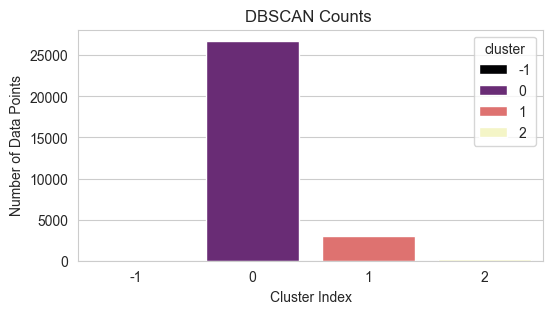

In [114]:
plot_cluster_counts(dbscan_result['cluster'], "DBSCAN", color='magma')

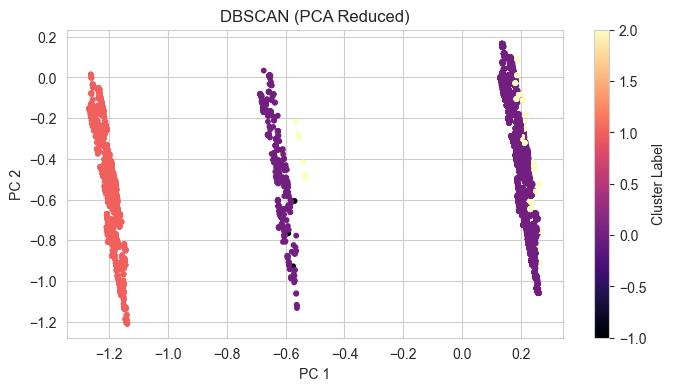

In [116]:
plot_scatter_clusters(X_preprocessed[:30000], dbscan_result['cluster'], "DBSCAN", components=(0, 1), color='magma')

# Training

In [46]:
X_preprocessed = pd.read_parquet('clean/X_preprocessed_train.parquet')
X_preprocessed.shape

(247741, 52)

In [47]:
clustering_pipelines = {
    'KMeans': Pipeline([
        ('clf', KMeans(n_clusters=5, random_state=42)),
    ]),
    'HDBSCAN': Pipeline([
        # ('clf', HDBSCAN(cluster_selection_epsilon=2.5, min_samples=53)),
        ('clf', HDBSCAN(cluster_selection_epsilon=0.5, min_samples=53)),
    ]),
    'Agglomerative': Pipeline([
        ('clf', AgglomerativeClustering(n_clusters=5)),
    ]),
}

In [9]:
classification_pipelines = {
    'RandomForest': Pipeline([
        ('clf', RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100))
    ]),
    'SVM': Pipeline([
        ('clf', SVC(probability=True))
    ]),
    'CatBoost': Pipeline([
        ('clf', CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_seed=42, verbose=True)),
    ]),
}

In [14]:
X = X_preprocessed[:30000]
results = {}

for cluster_name, cluster_pipeline in clustering_pipelines.items():
    print(f"\nFitting clustering pipeline: {cluster_name}")

    if hasattr(cluster_pipeline, 'named_steps'):
        cluster_pipeline.fit(X)
    else:
        cluster_pipeline.fit(X)

    X_clustered = cluster_pipeline.fit_predict(X)

    clustering_model = cluster_pipeline.named_steps['clf']
    if hasattr(clustering_model, 'labels_'):
        labels = clustering_model.labels_
    elif hasattr(clustering_model, 'predict'):
        labels = clustering_model.predict(X_clustered)
    else:
        raise ValueError(f"Model {cluster_name} does not support label extraction.")

    valid_indices = labels != -1
    X_valid = X[valid_indices]
    y_valid = labels[valid_indices]

    train_size = int(len(X) * 0.8)
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = labels[:train_size]
    y_test = labels[train_size:]

    results[cluster_name] = {}

    for clf_name, clf_pipeline in classification_pipelines.items():
        print(f"  Training classifier: {clf_name}")

        clf_pipeline.fit(X_train, y_train)
        y_pred = clf_pipeline.predict(X_test)

        classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
        f1_score = classification_report_df.loc['weighted avg', 'f1-score']
        results[cluster_name][clf_name] = round(f1_score, 4)
        print(f"    F-1 score: {f1_score:.4f}")


Fitting clustering pipeline: KMeans


python(57196) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Training classifier: RandomForest
    Accuracy: 0.7608
  Training classifier: SVM
    Accuracy: 0.7720
  Training classifier: CatBoost
0:	learn: 1.1226135	total: 71ms	remaining: 1m 10s
1:	learn: 0.9448812	total: 127ms	remaining: 1m 3s
2:	learn: 0.8072019	total: 178ms	remaining: 59.1s
3:	learn: 0.6961716	total: 227ms	remaining: 56.5s
4:	learn: 0.6087383	total: 292ms	remaining: 58s
5:	learn: 0.5372408	total: 345ms	remaining: 57.1s
6:	learn: 0.4764064	total: 420ms	remaining: 59.5s
7:	learn: 0.4234558	total: 499ms	remaining: 1m 1s
8:	learn: 0.3778282	total: 556ms	remaining: 1m 1s
9:	learn: 0.3383995	total: 623ms	remaining: 1m 1s
10:	learn: 0.3042354	total: 679ms	remaining: 1m 1s
11:	learn: 0.2744443	total: 724ms	remaining: 59.6s
12:	learn: 0.2481020	total: 777ms	remaining: 59s
13:	learn: 0.2249499	total: 814ms	remaining: 57.3s
14:	learn: 0.2035542	total: 849ms	remaining: 55.7s
15:	learn: 0.1846999	total: 885ms	remaining: 54.4s
16:	learn: 0.1679492	total: 921ms	remaining: 53.3s
17:	learn:

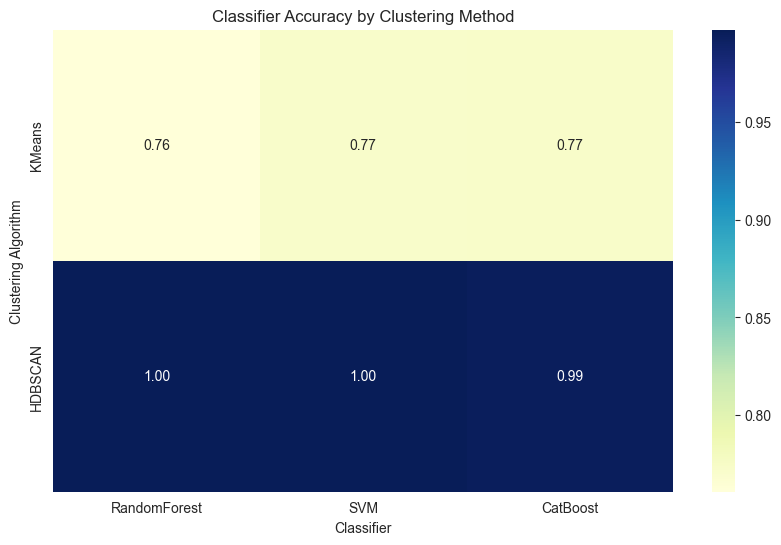

In [15]:
results_df = pd.DataFrame(results).T

plot_heatmap(results_df)

## Training Pipeline with New Features

In [11]:
X_preprocessed = pd.read_parquet('clean/X_preprocessed_train_2.parquet')
X_preprocessed.shape

(248687, 18)

In [29]:
clustering_pipelines = {
    'KMeans': Pipeline([
        ('clf', KMeans(n_clusters=3, random_state=42)),
    ]),
    'HDBSCAN': Pipeline([
        ('clf', HDBSCAN(cluster_selection_epsilon=1, min_samples=19)),
    ]),
    'Agglomerative': Pipeline([
        ('clf', AgglomerativeClustering(n_clusters=3)),
    ]),
}

In [30]:
classification_pipelines = {
    'RandomForest': Pipeline([
        ('clf', RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100))
    ]),
    'SVM': Pipeline([
        ('clf', SVC(probability=True))
    ]),
    'CatBoost': Pipeline([
        ('clf', CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_seed=42, verbose=True)),
    ]),
}

In [41]:
X = X_preprocessed[:30000]

results = {}
conf_matrix_df = []
classification_report_df = []
f1_scores_df = []
pr_curves_df = []
avg_precision_df = []

for cluster_name, cluster_pipeline in clustering_pipelines.items():
    print(f"\nFitting clustering pipeline: {cluster_name}")

    cluster_pipeline.fit(X)
    X_clustered = cluster_pipeline.fit_predict(X)

    clustering_model = cluster_pipeline.named_steps['clf']
    if hasattr(clustering_model, 'labels_'):
        labels = clustering_model.labels_
    elif hasattr(clustering_model, 'predict'):
        labels = clustering_model.predict(X_clustered)
    else:
        raise ValueError(f"Model {cluster_name} does not support label extraction.")

    valid_indices = labels != -1
    X_valid = X[valid_indices]
    y_valid = labels[valid_indices]

    train_size = int(len(X_valid) * 0.8)
    X_train = X_valid.iloc[:train_size]
    X_test = X_valid.iloc[train_size:]
    y_train = y_valid[:train_size]
    y_test = y_valid[train_size:]

    results[cluster_name] = {}

    for clf_name, clf_pipeline in classification_pipelines.items():
        print(f"  Training classifier: {clf_name}")

        clf_pipeline.fit(X_train, y_train)
        y_pred = clf_pipeline.predict(X_test)

        f1 = f1_score(y_test, y_pred, average='weighted')
        results[cluster_name][clf_name] = round(f1, 4)
        print(f"    F-1 score: {f1:.4f}")

        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        if hasattr(clf_pipeline.named_steps['clf'], "predict_proba"):
            y_scores = clf_pipeline.predict_proba(X_test)
            n_classes = y_scores.shape[1]
        elif hasattr(clf_pipeline.named_steps['clf'], "decision_function"):
            y_scores = clf_pipeline.decision_function(X_test)
            if len(np.unique(y_train)) == 2:
                y_scores = np.vstack([1 - y_scores, y_scores]).T
            n_classes = y_scores.shape[1]
        else:
            y_scores = None
            n_classes = len(np.unique(y_test))

        if y_scores is not None:
            for i in range(n_classes):
                if np.sum(y_test == i) == 0:
                    print(f"    Skipping PR curve for class {i} (no samples in y_test)")
                    continue

                binary_true = (y_test == i).astype(int)
                binary_score = y_scores[:, i]

                precision, recall, _ = precision_recall_curve(binary_true, binary_score)
                avg_prec = average_precision_score(binary_true, binary_score)

                pr_curves_df.append({
                    'cluster_model': cluster_name,
                    'classifier_model': clf_name,
                    'class': i,
                    'precision': precision.tolist(),
                    'recall': recall.tolist()
                })
                avg_precision_df.append({
                    'cluster_model': cluster_name,
                    'classifier_model': clf_name,
                    'class': i,
                    'avg_precision': avg_prec
                })

        f1_scores_df.append({
            'cluster_model': cluster_name,
            'classifier_model': clf_name,
            'f1_score': f1
        })
        conf_matrix_df.append({
            'cluster_model': cluster_name,
            'classifier_model': clf_name,
            'conf_matrix': cm.tolist()
        })
        classification_report_df.append({
            'cluster_model': cluster_name,
            'classifier_model': clf_name,
            'report': report
        })


Fitting clustering pipeline: KMeans
  Training classifier: RandomForest
    F-1 score: 0.8884
    Skipping PR curve for class 2 (no samples in y_test)
  Training classifier: SVM
    F-1 score: 0.9706
    Skipping PR curve for class 2 (no samples in y_test)
  Training classifier: CatBoost
0:	learn: 0.9156254	total: 7.01ms	remaining: 7s
1:	learn: 0.7803496	total: 12.5ms	remaining: 6.26s
2:	learn: 0.6740906	total: 18.3ms	remaining: 6.08s
3:	learn: 0.5869360	total: 24.6ms	remaining: 6.12s
4:	learn: 0.5149838	total: 36.4ms	remaining: 7.25s
5:	learn: 0.4562806	total: 61.3ms	remaining: 10.2s
6:	learn: 0.4038978	total: 97.8ms	remaining: 13.9s
7:	learn: 0.3598179	total: 134ms	remaining: 16.6s
8:	learn: 0.3216348	total: 141ms	remaining: 15.5s
9:	learn: 0.2880552	total: 148ms	remaining: 14.7s
10:	learn: 0.2605779	total: 157ms	remaining: 14.1s
11:	learn: 0.2345651	total: 189ms	remaining: 15.6s
12:	learn: 0.2129352	total: 197ms	remaining: 15s
13:	learn: 0.1919619	total: 203ms	remaining: 14.3s
14:	

In [32]:
conf_matrix_df = pd.DataFrame(conf_matrix_df)
classification_report_df = pd.DataFrame(classification_report_df)
f1_scores_df = pd.DataFrame(f1_scores_df)
pr_curves_df = pd.DataFrame(pr_curves_df)
avg_precision_df = pd.DataFrame(avg_precision_df)
results_df = pd.DataFrame(results).T

# conf_matrix_df.to_csv('confusion_matrices_30k.csv', index=False)
# classification_report_df.to_csv('classification_reports_30k.csv', index=False)
# f1_scores_df.to_csv('f1_scores_30k.csv', index=False)
# pr_curves_df.to_csv('pr_curves_30k.csv', index=False)
# avg_precision_df.to_csv('avg_precision_30k.csv', index=False)
results_df.to_csv('results_30k.csv', index=False)

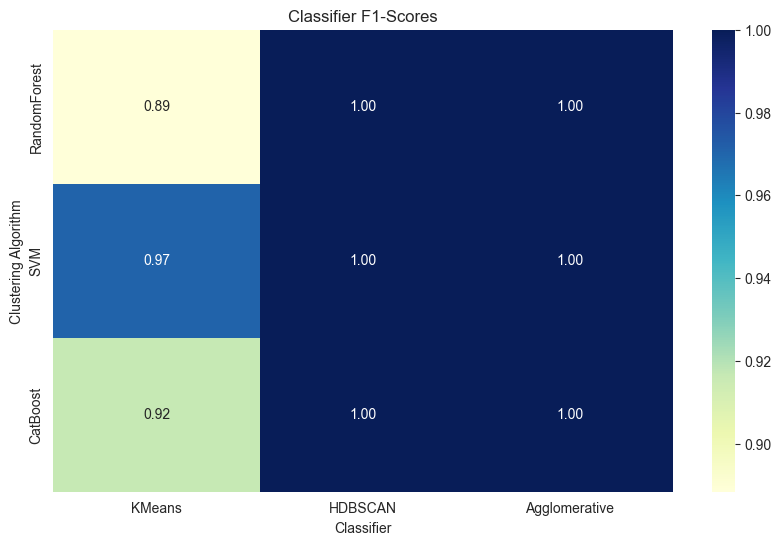

In [44]:
plot_heatmap(results_df)

In [ ]:
def plot_pr_curves(cluster_model_name, classifier_model_name):
    subset = pr_curves_df[
        (pr_curves_df['cluster_model'] == cluster_model_name) &
        (pr_curves_df['classifier_model'] == classifier_model_name)
    ]

    plt.figure(figsize=(10, 6))
    for _, row in subset.iterrows():
        plt.plot(row['recall'], row['precision'], label=f"Class {row['class']}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve\n{cluster_model_name} + {classifier_model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pr_curves("KMeans", "RandomForest")

#### Training with Isolation Forest

In [ ]:
X_preprocessed = pd.read_parquet('clean/X_preprocessed_train_3.parquet')
X_preprocessed.shape

In [144]:
clustering_pipelines = {
    'KMeans': Pipeline([
        ('clf', KMeans(n_clusters=4, random_state=42)),
    ]),
    'DBSCAN': Pipeline([
        ('clf', DBSCAN(eps=1, min_samples=19)),
    ]),
    'Agglomerative': Pipeline([
        ('clf', AgglomerativeClustering(n_clusters=4)),
    ]),
}

In [35]:
classification_pipelines = {
    'RandomForest': Pipeline([
        ('clf', RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100))
    ]),
    'SVM': Pipeline([
        ('clf', SVC(probability=True))
    ]),
    'CatBoost': Pipeline([
        ('clf', CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_seed=42, verbose=True)),
    ]),
}

In [146]:
X = X_preprocessed[:30000]

results = {}
conf_matrix_df = []
classification_report_df = []
f1_scores_df = []
pr_curves_df = []
avg_precision_df = []

for cluster_name, cluster_pipeline in clustering_pipelines.items():
    print(f"\nFitting clustering pipeline: {cluster_name}")

    cluster_pipeline.fit(X)
    X_clustered = cluster_pipeline.fit_predict(X)

    clustering_model = cluster_pipeline.named_steps['clf']
    if hasattr(clustering_model, 'labels_'):
        labels = clustering_model.labels_
    elif hasattr(clustering_model, 'predict'):
        labels = clustering_model.predict(X_clustered)
    else:
        raise ValueError(f"Model {cluster_name} does not support label extraction.")

    valid_indices = labels != -1  # noise labels
    X_valid = X[valid_indices]
    y_valid = labels[valid_indices]

    train_size = int(len(X_valid) * 0.8)
    X_train = X_valid.iloc[:train_size]
    X_test = X_valid.iloc[train_size:]
    y_train = y_valid[:train_size]
    y_test = y_valid[train_size:]

    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    iso_forest.fit(X_train)

    train_scores = iso_forest.decision_function(X_train).reshape(-1, 1)  # shape (n_samples, 1)
    test_scores = iso_forest.decision_function(X_test).reshape(-1, 1)

    X_train_with_iso = np.hstack([X_train, train_scores])
    X_test_with_iso = np.hstack([X_test, test_scores])

    results[cluster_name] = {}

    for clf_name, clf_pipeline in classification_pipelines.items():
        print(f"  Training classifier: {clf_name}")

        clf_pipeline.fit(X_train_with_iso, y_train)
        y_pred = clf_pipeline.predict(X_test_with_iso)

        f1 = f1_score(y_test, y_pred, average='weighted')
        results[cluster_name][clf_name] = round(f1, 4)
        print(f"    F-1 score: {f1:.4f}")

        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        if hasattr(clf_pipeline.named_steps['clf'], "predict_proba"):
            y_scores = clf_pipeline.predict_proba(X_test_with_iso)
            n_classes = y_scores.shape[1]
        elif hasattr(clf_pipeline.named_steps['clf'], "decision_function"):
            y_scores = clf_pipeline.decision_function(X_test_with_iso)
            if len(np.unique(y_train)) == 2:
                y_scores = np.vstack([1 - y_scores, y_scores]).T
            n_classes = y_scores.shape[1]
        else:
            y_scores = None
            n_classes = len(np.unique(y_test))

        if y_scores is not None:
            for i in range(n_classes):
                if np.sum(y_test == i) == 0:
                    print(f"    Skipping PR curve for class {i} (no samples in y_test)")
                    continue

                binary_true = (y_test == i).astype(int)
                binary_score = y_scores[:, i]

                precision, recall, _ = precision_recall_curve(binary_true, binary_score)
                avg_prec = average_precision_score(binary_true, binary_score)

                pr_curves_df.append({
                    'cluster_model': cluster_name,
                    'classifier_model': clf_name,
                    'class': i,
                    'precision': precision.tolist(),
                    'recall': recall.tolist()
                })
                avg_precision_df.append({
                    'cluster_model': cluster_name,
                    'classifier_model': clf_name,
                    'class': i,
                    'avg_precision': avg_prec
                })

        f1_scores_df.append({
            'cluster_model': cluster_name,
            'classifier_model': clf_name,
            'f1_score': f1
        })
        conf_matrix_df.append({
            'cluster_model': cluster_name,
            'classifier_model': clf_name,
            'conf_matrix': cm.tolist()
        })
        classification_report_df.append({
            'cluster_model': cluster_name,
            'classifier_model': clf_name,
            'report': report
        })


Fitting clustering pipeline: KMeans
  Training classifier: RandomForest
    F-1 score: 0.9650
    Skipping PR curve for class 2 (no samples in y_test)
  Training classifier: SVM
    F-1 score: 0.9112
    Skipping PR curve for class 2 (no samples in y_test)
  Training classifier: CatBoost
0:	learn: 1.1290447	total: 69.9ms	remaining: 34.9s
1:	learn: 0.9554007	total: 92.9ms	remaining: 23.1s
2:	learn: 0.8225941	total: 106ms	remaining: 17.5s
3:	learn: 0.7159724	total: 152ms	remaining: 18.8s
4:	learn: 0.6291949	total: 166ms	remaining: 16.4s
5:	learn: 0.5595823	total: 177ms	remaining: 14.5s
6:	learn: 0.4980303	total: 207ms	remaining: 14.6s
7:	learn: 0.4468086	total: 234ms	remaining: 14.4s
8:	learn: 0.4036097	total: 261ms	remaining: 14.2s
9:	learn: 0.3629627	total: 269ms	remaining: 13.2s
10:	learn: 0.3283368	total: 277ms	remaining: 12.3s
11:	learn: 0.2971474	total: 287ms	remaining: 11.7s
12:	learn: 0.2707078	total: 295ms	remaining: 11.1s
13:	learn: 0.2464597	total: 307ms	remaining: 10.6s
14:	

In [147]:
conf_matrix_df = pd.DataFrame(conf_matrix_df)
classification_report_df = pd.DataFrame(classification_report_df)
f1_scores_df = pd.DataFrame(f1_scores_df)
pr_curves_df = pd.DataFrame(pr_curves_df)
avg_precision_df = pd.DataFrame(avg_precision_df)
results_df = pd.DataFrame(results).T

# Save all DataFrames to CSV
# conf_matrix_df.to_csv('confusion_matrices_30k_iso_3.csv', index=False)
# classification_report_df.to_csv('classification_reports_30k_iso_3.csv', index=False)
# f1_scores_df.to_csv('f1_scores_30k_iso_3.csv', index=False)
# pr_curves_df.to_csv('pr_curves_30k_iso_3.csv', index=False)
# avg_precision_df.to_csv('avg_precision_30k_iso_3.csv', index=False)
# results_df.to_csv('results_30k_iso_3.csv', index=False)

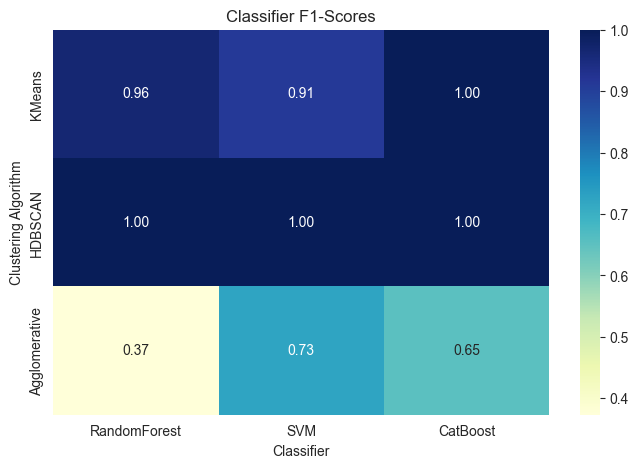

In [148]:
plot_heatmap(results_df)

/var/folders/z_/1mhq8btn6gbc98x34n2gwck80000gn/T/ipykernel_53562/2769271969.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  confusion_matrix = np.array(conf_matrix_df[conf_matrix_df['cluster_model'] == 'KMeans'][conf_matrix_df['classifier_model'] == 'RandomForest']['conf_matrix'].values[0])


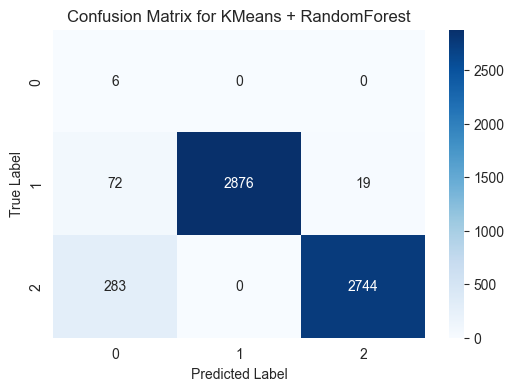

In [153]:
confusion_matrix = np.array(conf_matrix_df[conf_matrix_df['cluster_model'] == 'KMeans'][conf_matrix_df['classifier_model'] == 'RandomForest']['conf_matrix'].values[0])
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for KMeans + RandomForest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show();

## Aglomerative Clustering

In [56]:
X_preprocessed = pd.read_parquet('clean/X_preprocessed_train.parquet')
X_preprocessed.shape

(247741, 52)

In [16]:
classification_pipelines = {
    'RandomForest': Pipeline([
        ('clf', RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100))
    ]),
    'SVM': Pipeline([
        ('clf', SVC(probability=True))
    ]),
    'CatBoost': Pipeline([
        ('clf', CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_seed=42, verbose=True)),
    ]),
}

In [9]:
X_aglo = pd.DataFrame(X_preprocessed)[:30000]

clustering = AgglomerativeClustering(n_clusters=5).fit(X_aglo)
labels_agglomerative = clustering.labels_

train_size = int(len(X_aglo) * 0.8)
X_train = X_aglo.iloc[:train_size]
X_test = X_aglo.iloc[train_size:]
y_train = labels[:train_size]
y_test = labels[train_size:]
cluster_name = "Agglomerative"
aglo_results = {cluster_name: {}}

for clf_name, clf_pipeline in classification_pipelines.items():
    print(f"  Training classifier: {clf_name}")

    clf_pipeline.fit(X_train, y_train)
    y_pred = clf_pipeline.predict(X_test)

    classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
    classification_report_df.to_csv(f'classification_report_{cluster_name}_{clf_name}.csv', index=False)
    f1_score = classification_report_df.loc['weighted avg', 'f1-score']
    aglo_results[cluster_name][clf_name] = round(f1_score, 4)
    print(f"    F1-Score: {f1_score:.4f}")

aglo_results.to_csv('aglo_results.csv', index=False)

  Training classifier: RandomForest


python(57030) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    Accuracy: 0.9313
  Training classifier: SVM
    Accuracy: 0.9648
  Training classifier: CatBoost
0:	learn: 1.2528753	total: 104ms	remaining: 1m 43s
1:	learn: 1.0356602	total: 130ms	remaining: 1m 4s
2:	learn: 0.8716675	total: 153ms	remaining: 50.9s
3:	learn: 0.7457276	total: 182ms	remaining: 45.3s
4:	learn: 0.6472124	total: 210ms	remaining: 41.8s
5:	learn: 0.5653023	total: 241ms	remaining: 39.9s
6:	learn: 0.4974032	total: 271ms	remaining: 38.5s
7:	learn: 0.4395266	total: 298ms	remaining: 36.9s
8:	learn: 0.3912078	total: 321ms	remaining: 35.4s
9:	learn: 0.3487850	total: 349ms	remaining: 34.5s
10:	learn: 0.3115329	total: 382ms	remaining: 34.3s
11:	learn: 0.2788203	total: 412ms	remaining: 34s
12:	learn: 0.2505738	total: 443ms	remaining: 33.6s
13:	learn: 0.2247779	total: 470ms	remaining: 33.1s
14:	learn: 0.2027752	total: 500ms	remaining: 32.8s
15:	learn: 0.1827781	total: 527ms	remaining: 32.4s
16:	learn: 0.1650141	total: 554ms	remaining: 32s
17:	learn: 0.1491936	total: 584ms	remaining: 

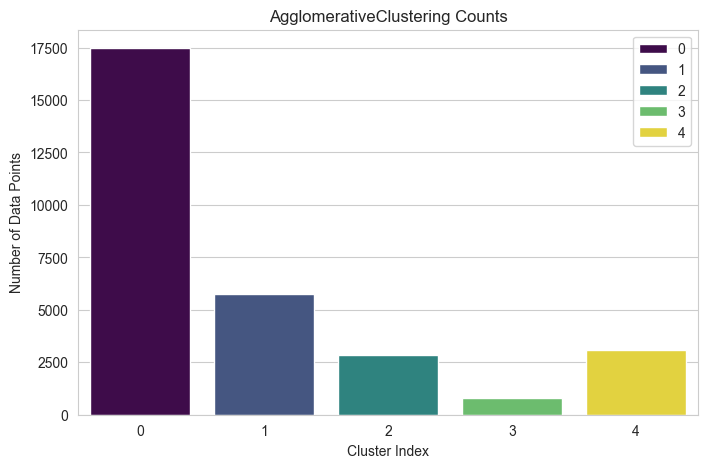

In [9]:
plot_cluster_counts(labels_agglomerative, "AgglomerativeClustering")

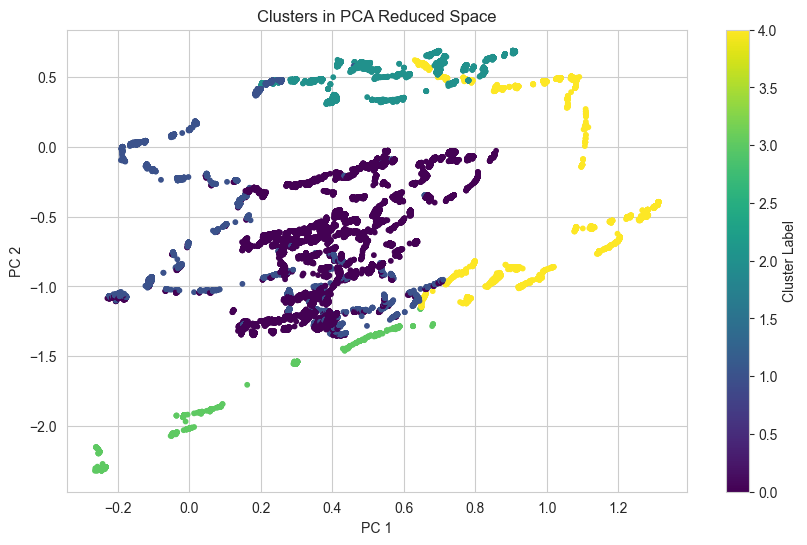

In [11]:
plot_scatter_clusters(X_aglo, labels_agglomerative, "AgglomerativeClustering")

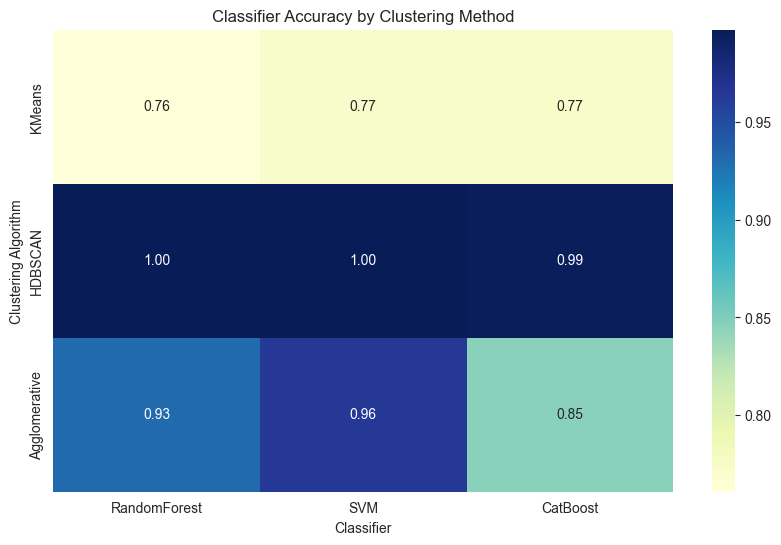

In [17]:
results.update(aglo_results)
results_df = pd.DataFrame(results).T

plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classifier Accuracy by Clustering Method")
plt.ylabel("Clustering Algorithm")
plt.xlabel("Classifier")
plt.show()

### AgglomerativeClustering 3 clusters

In [12]:
X_aglo = pd.DataFrame(X_preprocessed)[:30000]
clustering = AgglomerativeClustering(n_clusters=3).fit(X_aglo)
labels_agglomerative = clustering.labels_

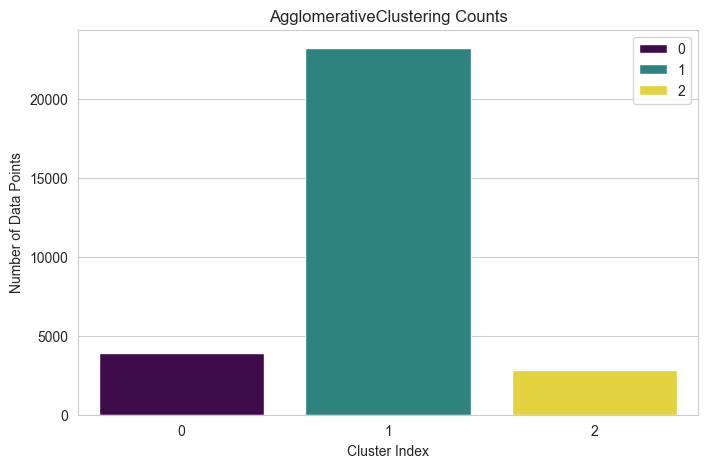

In [13]:
plot_cluster_counts(labels_agglomerative, "AgglomerativeClustering 3")

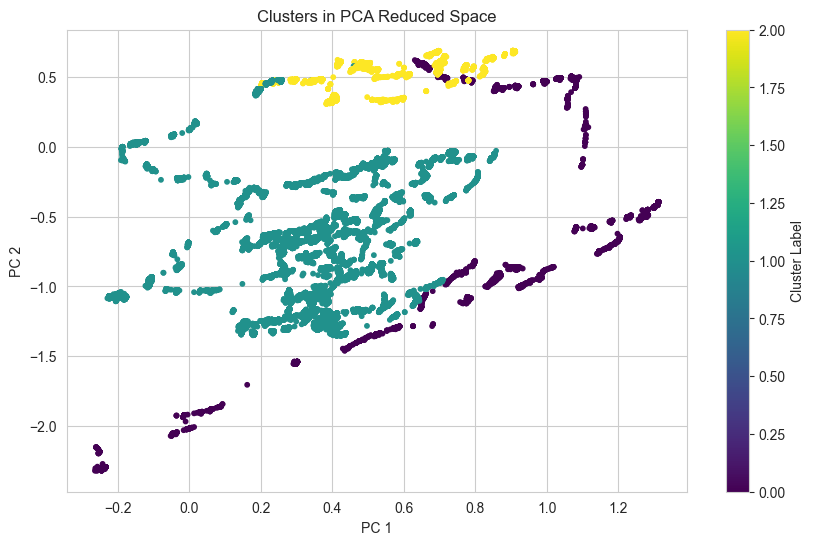

In [14]:
plot_scatter_clusters(X_aglo, labels_agglomerative, "AgglomerativeClustering 3")

### AgglomerativeClustering 8 clusters

In [ ]:
X_aglo = pd.DataFrame(X_preprocessed)[:100000]
clustering = AgglomerativeClustering(n_clusters=9).fit(X_aglo)
labels_agglomerative = clustering.labels_

In [ ]:
plot_cluster_counts(labels_agglomerative, "AgglomerativeClustering 8")

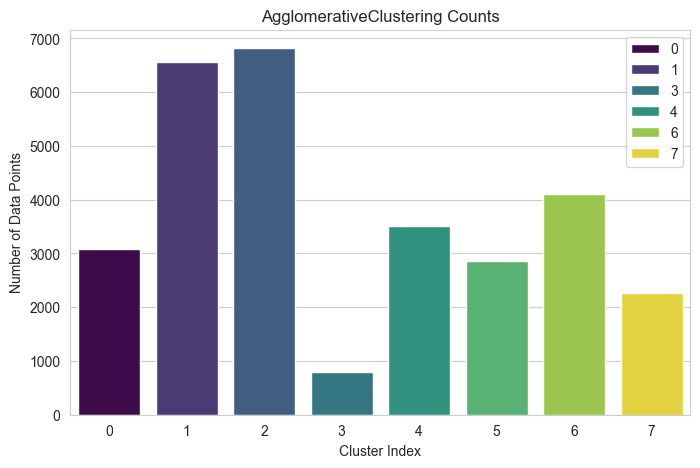

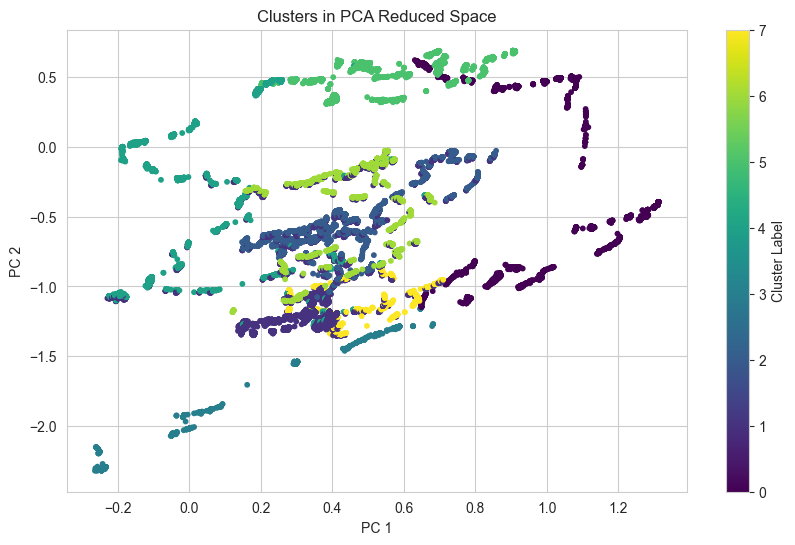

In [20]:
plot_scatter_clusters(X_aglo, labels_agglomerative, "AgglomerativeClustering 8")

In [ ]:
labels_df = train_df[:30000].copy()
labels_df['cluster'] = labels_agglomerative
# labels_df.to_parquet('clean/labels_df_aglo_8.parquet', compression='gzip')

In [49]:
labels_df.groupby('cluster').agg(['mean', 'std', 'min', 'max']).T

cluster                                  0              1             2  \
cpu_time_millis        mean   55334.235999   110032.65716  53046.843255   
                       std   393001.289625  943392.320988  317166.90122   
                       min               0              0             0   
                       max         9745917       20775846       9607098   
failed_cpu_time_millis mean            0.0            0.0       0.00132   
...                                    ...            ...           ...   
year                   max            2025           2025          2025   
dayofweek              mean            3.0       4.422907      4.297214   
                       std             0.0       0.585085      0.457065   
                       min               3              3             4   
                       max               3              5             5   

cluster                                  3              4              5  \
cpu_time_millis        mean   99630.500626   46946.882621    66890.05276   
                       std   966830.988806  328903.849794  504161.934782   
                       min               0              0              0   
                       max        18969721       10054933        9943998   
failed_cpu_time_millis mean            0.0       0.093162       0.020266   
...                                    ...            ...            ...   
year                   max            2025           2025           2025   
dayofweek              mean            3.0       3.047293            3.0   
                       std             0.0       0.276437            0.0   
                       min               3              3              3   
                       max               3              5              3   

cluster                                  6              7  
cpu_time_millis        mean   46257.797756   41678.973498  
                       std   194933.270496  193388.160998  
                       min               0              0  
                       max         1122401        2171230  
failed_cpu_time_millis mean            0.0            0.0  
...                                    ...            ...  
year                   max            2025           2025  
dayofweek              mean            5.0            4.0  
                       std             0.0            0.0  
                       min               5              4  
                       max               5              4  

[1148 rows x 8 columns]

### AgglomerativeClustering 3 New Features

In [17]:
X_preprocessed = pd.read_parquet('clean/X_preprocessed_train_2.parquet')
X_preprocessed.shape

(248687, 18)

In [18]:
X_aglo = pd.DataFrame(X_preprocessed)[:30000]
clustering = AgglomerativeClustering(n_clusters=3).fit(X_aglo)
labels_agglomerative = clustering.labels_

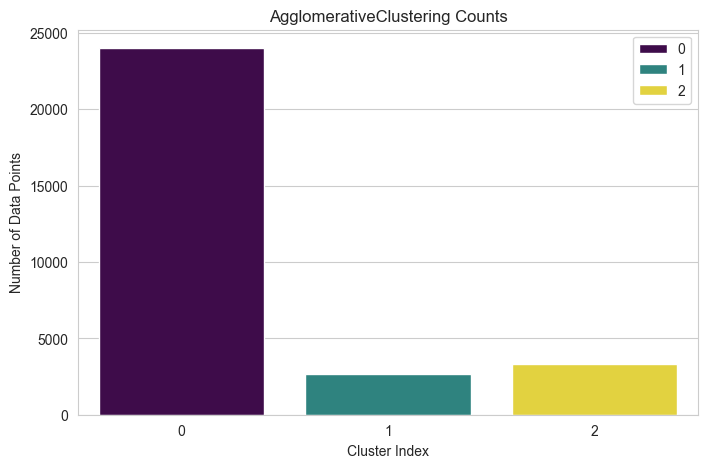

In [19]:
plot_cluster_counts(labels_agglomerative, "AgglomerativeClustering 3")

In [ ]:
plot_scatter_clusters(X_aglo, labels_agglomerative, "AgglomerativeClustering, 3 clusters")

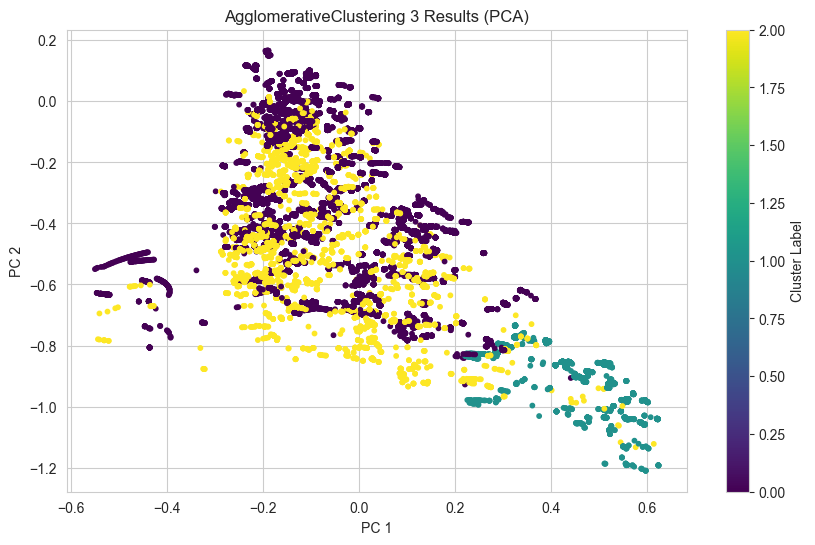

In [35]:
plot_scatter_clusters(X_aglo, labels_agglomerative, "AgglomerativeClustering 3", components=(1, 13,))

### AgglomerativeClustering 8 New Features

In [36]:
X_aglo = pd.DataFrame(X_preprocessed)[:30000]
clustering = AgglomerativeClustering(n_clusters=8).fit(X_aglo)
labels_agglomerative = clustering.labels_

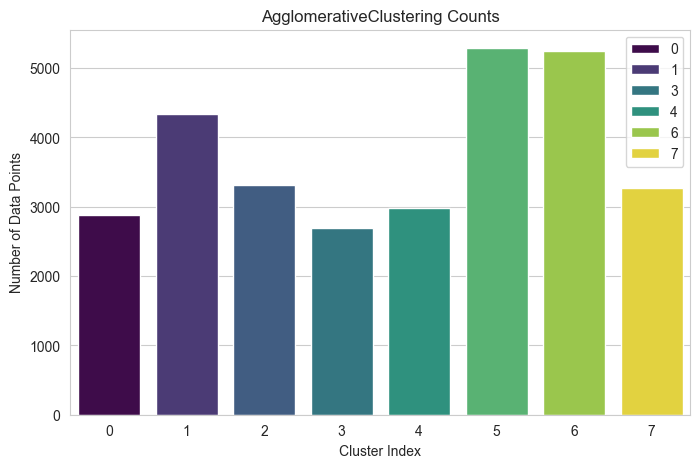

In [37]:
plt.figure(figsize=(8, 5))
sns.countplot(x=labels_agglomerative, palette='viridis', hue=labels_agglomerative)
plt.xlabel('Cluster Index')
plt.ylabel('Number of Data Points')
plt.title('AgglomerativeClustering Counts')
plt.show()

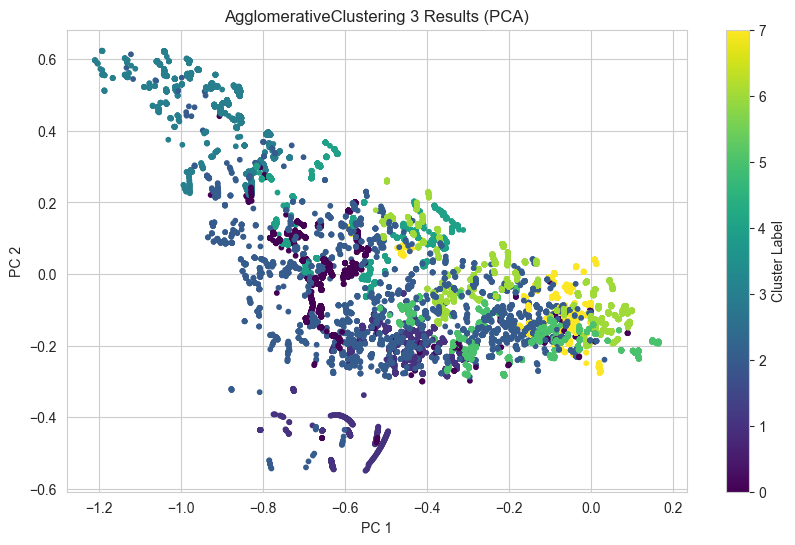

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(X_aglo[1], X_aglo[13], c=labels_agglomerative, cmap='viridis', s=10)
plt.title("AgglomerativeClustering 3 Results (PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='Cluster Label')
plt.show()

### AgglomerativeClustering Pipeline

In [ ]:
X_aglo = pd.DataFrame(X_preprocessed)[:100000]

clustering = AgglomerativeClustering(n_clusters=3).fit(X_aglo)
labels_agglomerative = clustering.labels_

train_size = int(len(X_aglo) * 0.8)
X_train = X_aglo.iloc[:train_size]
X_test = X_aglo.iloc[train_size:]
y_train = labels_agglomerative[:train_size]
y_test = labels_agglomerative[train_size:]
cluster_name = "Agglomerative"
aglo_results = {cluster_name: {}}

for clf_name, clf_pipeline in classification_pipelines.items():
    print(f"  Training classifier: {clf_name}")

    clf_pipeline.fit(X_train, y_train)
    y_pred = clf_pipeline.predict(X_test)

    classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
    classification_report_df.to_csv(f'classification_report_{cluster_name}_{clf_name}.csv', index=False)
    f1_score = classification_report_df.loc['weighted avg', 'f1-score']
    aglo_results[cluster_name][clf_name] = round(f1_score, 4)
    print(f"    F1-Score: {f1_score:.4f}")

aglo_results.to_csv('aglo_results.csv', index=False)

In [ ]:
aglo_results_df = pd.DataFrame(aglo_results).T

plt.figure(figsize=(10, 6))
sns.heatmap(aglo_results_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classifier Accuracy by Clustering Method")
plt.ylabel("Clustering Algorithm")
plt.xlabel("Classifier")
plt.show()

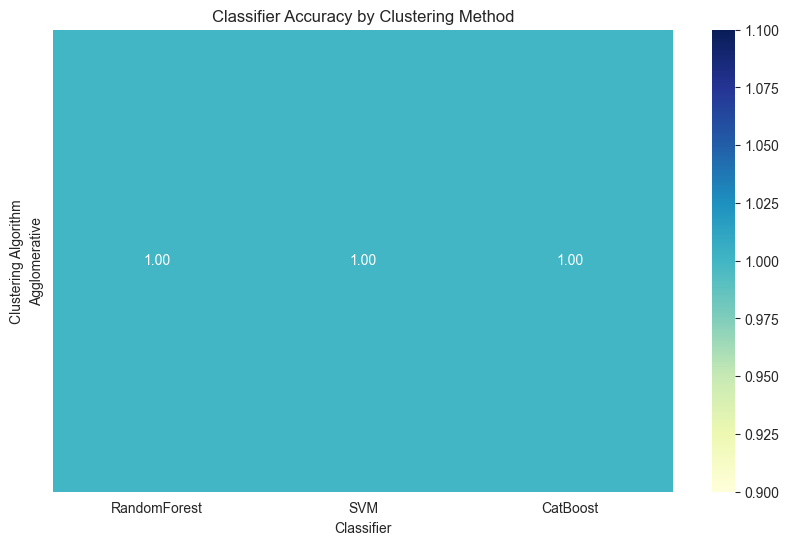

In [42]:
aglo_results_df = pd.DataFrame(aglo_results).T

plt.figure(figsize=(10, 6))
sns.heatmap(aglo_results_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classifier Accuracy by Clustering Method")
plt.ylabel("Clustering Algorithm")
plt.xlabel("Classifier")
plt.show()

## IsolationForest

In [40]:
from sklearn.ensemble import IsolationForest

X_preprocessed = pd.read_parquet('clean/X_preprocessed_train_2.parquet')
X_preprocessed.shape

(248687, 18)

In [41]:
train_size = int(len(X_preprocessed) * 0.8)
X_train = X_preprocessed.iloc[:train_size]
X_test = X_preprocessed.iloc[train_size:]
# y_train = labels[:train_size]
# y_test = labels[train_size:]

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)
iso_forest.fit(X_train)

IsolationForest(contamination=0.05, random_state=42)

In [42]:
pred_labels = iso_forest.predict(X_train)
scores = iso_forest.decision_function(X_train)

new_preds = iso_forest.predict(X_test)
new_scores = iso_forest.decision_function(X_test)

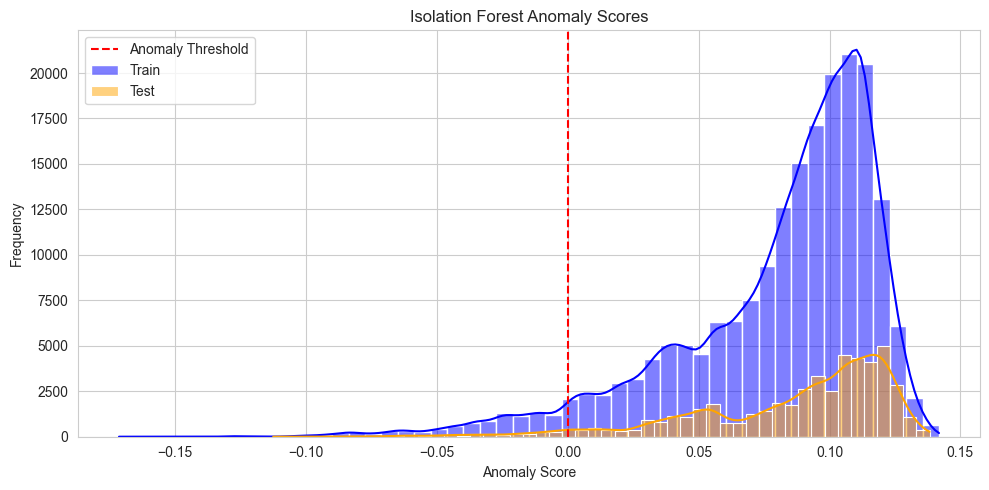

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(scores, bins=50, color='blue', label='Train', kde=True)
sns.histplot(new_scores, bins=50, color='orange', label='Test', kde=True)
plt.axvline(0, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# add scores to original data
train_df_sample = pd.DataFrame(train_df[:len(X_train)], columns=train_df.columns)
train_df_sample['anomaly_score'] = scores
train_df_sample['is_anomaly'] = pred_labels
test_df_sample = pd.DataFrame(test_df[:len(X_test)], columns=test_df.columns)
test_df_sample['anomaly_score'] = new_scores
test_df_sample['is_anomaly'] = new_preds

In [44]:
len(train_df), len(scores)

(248687, 198949)

In [13]:
pd.DataFrame(new_preds).value_counts()
# pd.DataFrame(pred_labels).value_counts()

0 
 1    47779
-1     1959
Name: count, dtype: int64

In [14]:
train_df_sample.groupby('is_anomaly').agg(['mean', 'std', 'min', 'max']).T

is_anomaly                               -1              1
cpu_time_millis        mean   512471.129792   43599.289741
                       std   2435607.044593  292056.231279
                       min                0              0
                       max        108803755       28741395
failed_cpu_time_millis mean       44.519469        0.06223
...                                     ...            ...
dayofweek_cos          max              1.0            1.0
anomaly_score          mean       -0.030856       0.086186
                       std         0.024783       0.030327
                       min         -0.17148            0.0
                       max        -0.000001       0.141839

[404 rows x 2 columns]

In [42]:
test_df_sample.groupby('is_anomaly').agg(['mean', 'std', 'min', 'max']).T

is_anomaly                              -1              1
cpu_time_millis        mean   53175.852986   64999.116913
                       std   451597.402729  661957.915957
                       min               0              0
                       max        13087782       29555268
failed_cpu_time_millis mean            0.0        1.11662
...                                    ...            ...
dayofweek_cos          max             1.0            1.0
anomaly_score          mean      -0.023726       0.090763
                       std         0.02109       0.031099
                       min        -0.11256       0.000018
                       max       -0.000009       0.138231

[404 rows x 2 columns]

### Compare Isolation Forest with Agglomerative

In [44]:
# ("clean/labels_df_aglo_8.parquet")
labels_df_aglo_8 = pd.read_parquet('clean/labels_df_aglo_8.parquet')
labels_df_aglo_8.shape, len(pred_labels)

((30000, 288), 198949)

In [49]:
labels_df_aglo_iso = labels_df_aglo_8.copy()
labels_df_aglo_iso['is_anomaly'] = pred_labels[:labels_df_aglo_8.shape[0]]
labels_df_aglo_iso.shape

(30000, 289)

In [52]:
labels_df_aglo_iso[labels_df_aglo_iso['cluster'] == 3].shape, labels_df_aglo_iso[labels_df_aglo_iso['is_anomaly'] == -1].shape

((799, 289), (3012, 289))

In [53]:
labels_df_aglo_iso[(labels_df_aglo_iso['is_anomaly'] == -1) &
                   (labels_df_aglo_iso['cluster'] == 3)].shape

(347, 289)

In [54]:
labels_df_aglo_iso[(labels_df_aglo_iso['is_anomaly'] == -1)]['cluster'].value_counts()

cluster
0    1500
3     347
5     342
1     318
4     153
2     143
7     133
6      76
Name: count, dtype: int64

## DBSCAN Clustering

In [136]:
dbscan_model =  DBSCAN(eps=1, min_samples=53)
DBSCAN_clusters = dbscan_model.fit_predict(X_preprocessed[:50000])

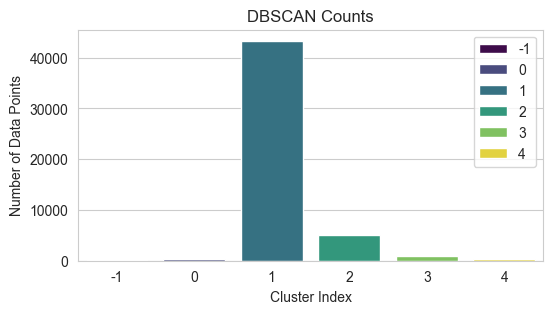

In [137]:
plot_cluster_counts(DBSCAN_clusters, "DBSCAN")

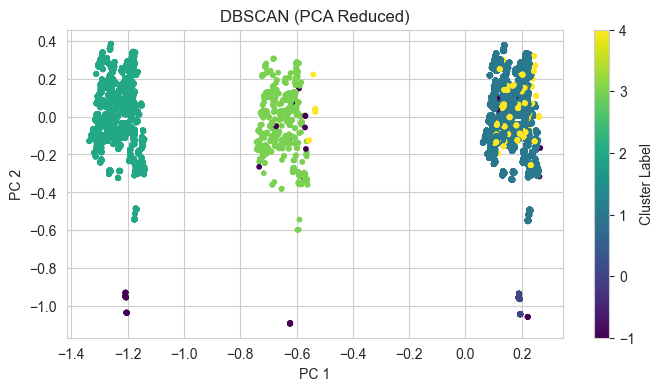

In [142]:
plot_scatter_clusters(X_preprocessed[:50000], DBSCAN_clusters, "DBSCAN", components=(0, 11))

In [27]:
import hdbscan

In [28]:
hdbscan_model_2 =  hdbscan.HDBSCAN(cluster_selection_epsilon=1.3, min_samples=53, prediction_data=True)
HDBSCAN_clusters_2 = hdbscan_model.fit_predict(X_preprocessed[:50000])

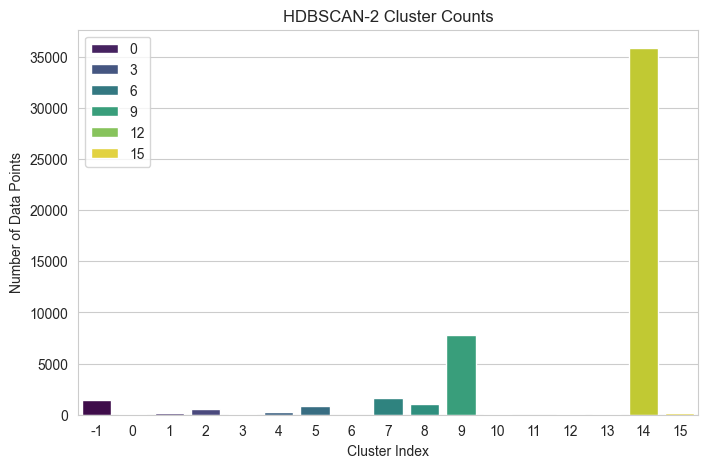

In [31]:
plt.figure(figsize=(8, 5))
sns.countplot(x=HDBSCAN_clusters_2, palette='viridis', hue=HDBSCAN_clusters_2)
plt.xlabel('Cluster Index')
plt.ylabel('Number of Data Points')
plt.title('HDBSCAN-2 Cluster Counts')
plt.show()

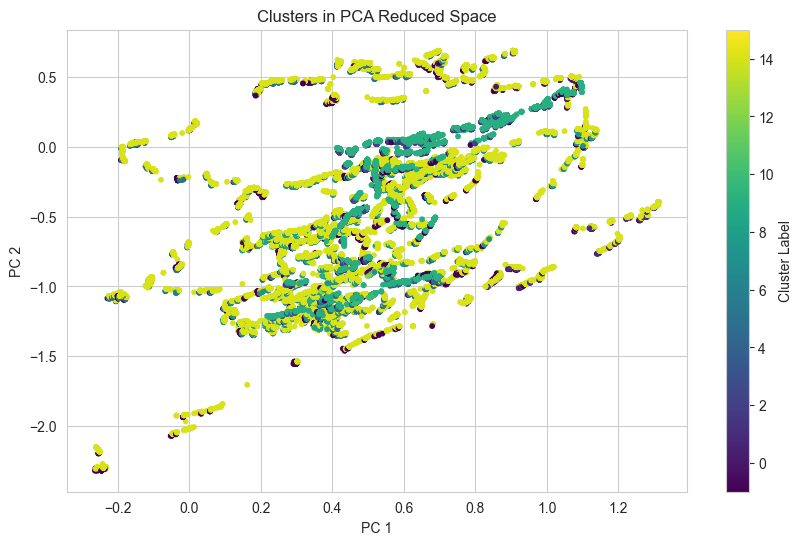

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(X_preprocessed[0][:50000], X_preprocessed[1][:50000], c=HDBSCAN_clusters_2, cmap='viridis', s=10)
plt.title("Clusters in PCA Reduced Space")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='Cluster Label')
plt.show()

In [41]:
hdbscan_model_test =  hdbscan.HDBSCAN(cluster_selection_epsilon=1.5, min_samples=53, prediction_data=True)
HDBSCAN_clusters_test = hdbscan_model_test.fit(X_preprocessed[:50000])
predictions_hdbscan_2 = hdbscan.approximate_predict(hdbscan_model_test, X_preprocessed[50000:70000])

/Users/elena.leonova/PycharmProjects/studying/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elena.leonova/PycharmProjects/studying/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [40]:
predictions_hdbscan_2

(array([53,  2, 53, ..., -1, -1, -1], dtype=int32),
 array([0.00313839, 0.88696852, 0.0031384 , ..., 0.        , 0.        ,
        0.        ]))

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x=predictions_hdbscan_2, palette='viridis', hue=predictions_hdbscan_2)
plt.xlabel('Cluster Index')
plt.ylabel('Number of Data Points')
plt.title('HDBSCAN-2 Cluster Counts')
plt.show()

## Birch, GaussianMixture, SpectralClustering

In [30]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch

X_preprocessed = pd.read_parquet('clean/X_preprocessed_train_3.parquet')
X_preprocessed.shape

(248687, 18)

In [32]:
clustering_pipelines_2 = {
    'GMM': Pipeline([
        ('clf', GaussianMixture(n_components=4)),
    ]),
    'Birch': Pipeline([
        ('clf', Birch(n_clusters=4)),
    ]),
}

In [37]:
X = X_preprocessed[:30000]
results = {}
conf_matrix_df = []
classification_report_df = []
f1_scores_df = []
pr_curves_df = []
avg_precision_df = []

for cluster_name, cluster_pipeline in clustering_pipelines_2.items():
    print(f"\nFitting clustering pipeline: {cluster_name}")

    try:
        X_clustered = cluster_pipeline.fit_predict(X)
    except AttributeError:
        cluster_pipeline.fit(X)
        clustering_model = cluster_pipeline.named_steps['clf']
        if hasattr(clustering_model, 'fit_predict'):
            X_clustered = clustering_model.fit_predict(X)
        elif hasattr(clustering_model, 'predict'):
            X_clustered = clustering_model.predict(X)
        else:
            raise ValueError(f"{cluster_name} model doesn't support clustering prediction.")

    labels = X_clustered

    train_size = int(len(X) * 0.8)
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = labels[:train_size]
    y_test = labels[train_size:]

    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    iso_forest.fit(X_train)

    train_scores = iso_forest.decision_function(X_train).reshape(-1, 1)
    test_scores = iso_forest.decision_function(X_test).reshape(-1, 1)

    X_train_with_iso = np.hstack([X_train, train_scores])
    X_test_with_iso = np.hstack([X_test, test_scores])

    results[cluster_name] = {}

    for clf_name, clf_pipeline in classification_pipelines.items():
        print(f"  Training classifier: {clf_name}")

        clf_pipeline.fit(X_train_with_iso, y_train)
        y_pred = clf_pipeline.predict(X_test_with_iso)

        f1 = f1_score(y_test, y_pred, average='weighted')
        results[cluster_name][clf_name] = round(f1, 4)
        print(f"    F-1 score: {f1:.4f}")

        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        if hasattr(clf_pipeline.named_steps['clf'], "predict_proba"):
            y_scores = clf_pipeline.predict_proba(X_test_with_iso)
            n_classes = y_scores.shape[1]
        elif hasattr(clf_pipeline.named_steps['clf'], "decision_function"):
            y_scores = clf_pipeline.decision_function(X_test_with_iso)
            if len(np.unique(y_train)) == 2:
                y_scores = np.vstack([1 - y_scores, y_scores]).T
            n_classes = y_scores.shape[1]
        else:
            y_scores = None
            n_classes = len(np.unique(y_test))

        if y_scores is not None:
            for i in range(n_classes):
                if np.sum(y_test == i) == 0:
                    print(f"    Skipping PR curve for class {i} (no samples in y_test)")
                    continue

                binary_true = (y_test == i).astype(int)
                binary_score = y_scores[:, i]

                precision, recall, _ = precision_recall_curve(binary_true, binary_score)
                avg_prec = average_precision_score(binary_true, binary_score)

                pr_curves_df.append({
                    'cluster_model': cluster_name,
                    'classifier_model': clf_name,
                    'class': i,
                    'precision': precision.tolist(),
                    'recall': recall.tolist()
                })
                avg_precision_df.append({
                    'cluster_model': cluster_name,
                    'classifier_model': clf_name,
                    'class': i,
                    'avg_precision': avg_prec
                })

        f1_scores_df.append({
            'cluster_model': cluster_name,
            'classifier_model': clf_name,
            'f1_score': f1
        })
        conf_matrix_df.append({
            'cluster_model': cluster_name,
            'classifier_model': clf_name,
            'conf_matrix': cm.tolist()
        })
        classification_report_df.append({
            'cluster_model': cluster_name,
            'classifier_model': clf_name,
            'report': report
        })


Fitting clustering pipeline: GMM
  Training classifier: RandomForest
    F-1 score: 0.8221
    Skipping PR curve for class 2 (no samples in y_test)
  Training classifier: SVM
    F-1 score: 0.8245
    Skipping PR curve for class 2 (no samples in y_test)
  Training classifier: CatBoost
0:	learn: 1.1241845	total: 97.3ms	remaining: 48.5s
1:	learn: 0.9464326	total: 106ms	remaining: 26.4s
2:	learn: 0.8135807	total: 115ms	remaining: 19s
3:	learn: 0.7073689	total: 123ms	remaining: 15.2s
4:	learn: 0.6207276	total: 131ms	remaining: 13s
5:	learn: 0.5500221	total: 139ms	remaining: 11.5s
6:	learn: 0.4886981	total: 148ms	remaining: 10.4s
7:	learn: 0.4383787	total: 156ms	remaining: 9.62s
8:	learn: 0.3932926	total: 166ms	remaining: 9.03s
9:	learn: 0.3544718	total: 174ms	remaining: 8.54s
10:	learn: 0.3211197	total: 183ms	remaining: 8.14s
11:	learn: 0.2900918	total: 192ms	remaining: 7.8s
12:	learn: 0.2625843	total: 202ms	remaining: 7.58s
13:	learn: 0.2390457	total: 212ms	remaining: 7.37s
14:	learn: 0.

In [38]:
conf_matrix_df = pd.DataFrame(conf_matrix_df)
classification_report_df = pd.DataFrame(classification_report_df)
f1_scores_df = pd.DataFrame(f1_scores_df)
pr_curves_df = pd.DataFrame(pr_curves_df)
avg_precision_df = pd.DataFrame(avg_precision_df)
results_df = pd.DataFrame(results).T

# Save all DataFrames to CSV
# conf_matrix_df.to_csv('confusion_matrices_30k_3_second_pipe.csv', index=False)
# classification_report_df.to_csv('classification_reports_30k_3_second_pipe.csv', index=False)
# f1_scores_df.to_csv('f1_scores_30k_3_second_pipe.csv', index=False)
# pr_curves_df.to_csv('pr_curves_30k_3_second_pipe.csv', index=False)
# avg_precision_df.to_csv('avg_precision_30k_3_second_pipe.csv', index=False)
# results_df.to_csv('results_30k_3_second_pipe.csv', index=False)

In [59]:
classification_report_df[(classification_report_df['cluster_model'] == 'Birch') & (classification_report_df['classifier_model'] == 'RandomForest')]['report'].values[0]

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5282.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 26.0},
 '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92.0},
 '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 600.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 6000.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 6000.0}}

In [51]:
results_df_1 = pd.read_csv('results_30k_iso_3.csv')
results_df_2 = pd.read_csv('results_30k_3_second_pipe.csv')

results_df_1.index = ['Agglomerative', 'DBSCAN', 'KMeans']
results_df_2.index = ['GMM', 'Birch']

results_total = pd.concat([results_df_1, results_df_2], axis=0)
# results_total.to_csv('results_total_15_pairs.csv', index=False)

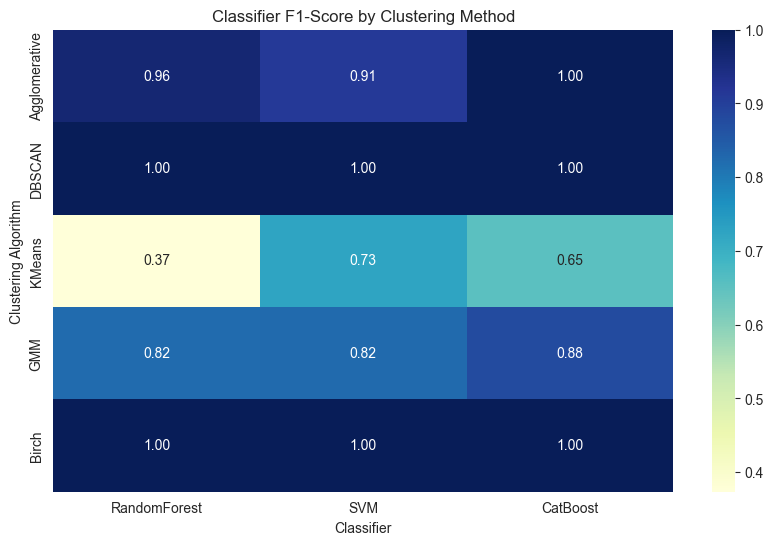

In [50]:
plt.figure(figsize=(10, 6))
sns.heatmap(results_total, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classifier F1-Score by Clustering Method")
plt.ylabel("Clustering Algorithm")
plt.xlabel("Classifier")
plt.show()

## GaussianMixture

### Hyperparameters Tuning

In [113]:
X_sample = X_preprocessed[:50000]
X_preprocessed.shape, X_sample.shape

((248687, 18), (50000, 18))

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

bic_scores = []
aic_scores = []
log_likelihoods = []
n_components_range = range(1, 19)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_sample)  # Make sure to scale your data
    bic_scores.append(gmm.bic(X_sample))
    aic_scores.append(gmm.aic(X_sample))
    log_likelihoods.append(gmm.score(X_sample) * len(X_sample))

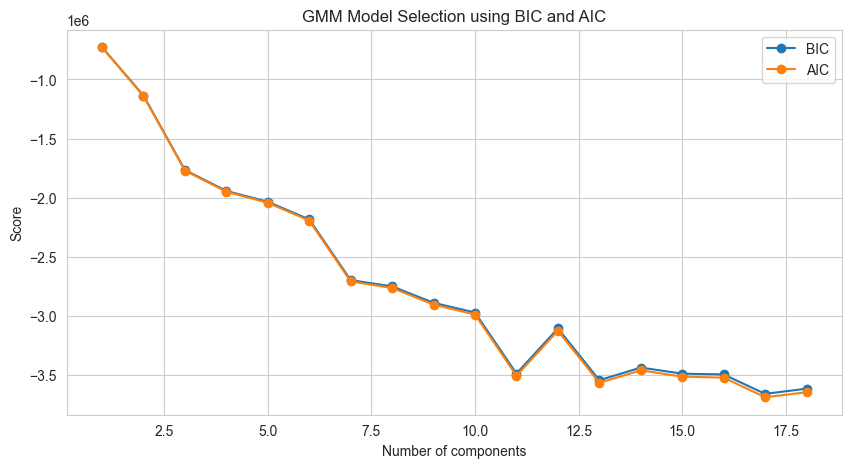

In [115]:
# Plot BIC and AIC
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('GMM Model Selection using BIC and AIC')
plt.legend()
plt.grid(True)
plt.show()

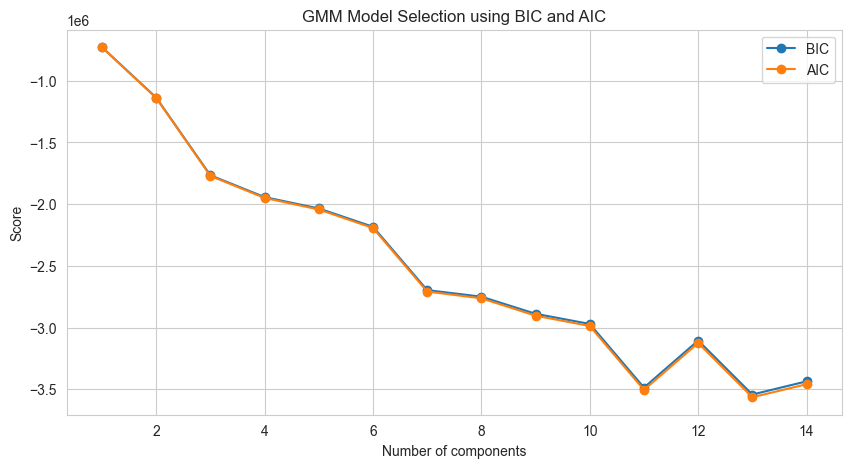

In [111]:
# Plot BIC and AIC
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('GMM Model Selection using BIC and AIC')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate data for Gaussian distributions

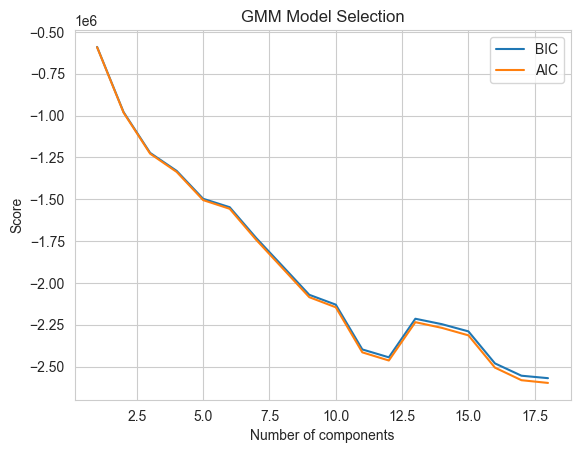

In [58]:
from sklearn.mixture import GaussianMixture
import numpy as np

# X = data[['feature1', 'feature2']]  # or more features
X = X_preprocessed[:30000]
bic_scores = []
aic_scores = []
n_components_range = range(1, 19)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))

# Plot BIC/AIC
plt.plot(n_components_range, bic_scores, label='BIC')
plt.plot(n_components_range, aic_scores, label='AIC')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.legend()
plt.title('GMM Model Selection')
plt.show()

In [14]:
gmm_model = GaussianMixture(n_components=3)
GMM_clusters = gmm_model.fit_predict(X_preprocessed)

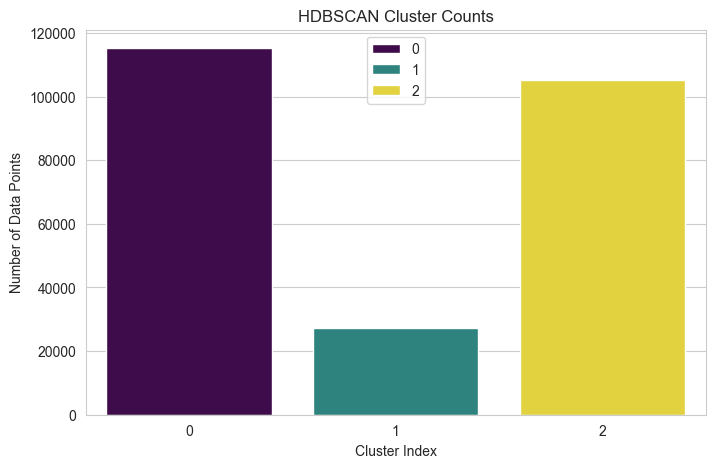

In [16]:
plt.figure(figsize=(8, 5))
sns.countplot(x=GMM_clusters, palette='viridis', hue=GMM_clusters)
plt.xlabel('Cluster Index')
plt.ylabel('Number of Data Points')
plt.title('GaussianMixture Cluster Counts')
plt.show()

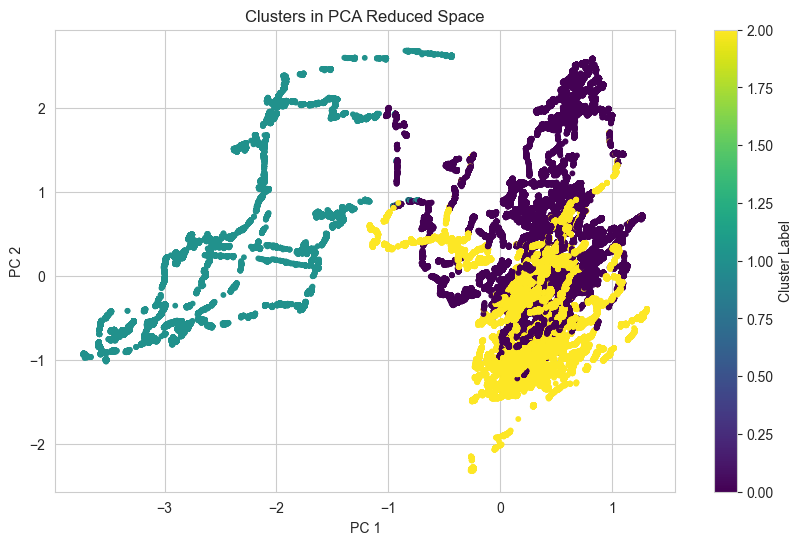

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(X_preprocessed[0], X_preprocessed[1], c=GMM_clusters, cmap='viridis', s=10)
plt.title("Clusters in PCA Reduced Space")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='Cluster Label')
plt.show()

## Birch

In [18]:
birch_model = Birch(n_clusters=3)
birch_clusters = birch_model.fit_predict(X_preprocessed)

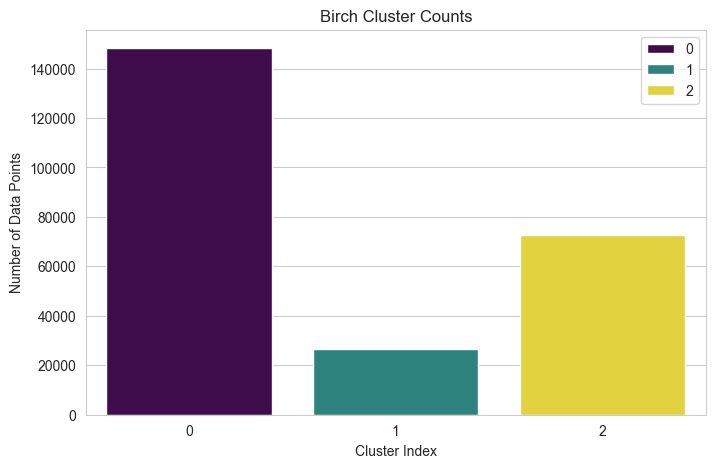

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x=birch_clusters, palette='viridis', hue=birch_clusters)
plt.xlabel('Cluster Index')
plt.ylabel('Number of Data Points')
plt.title('Birch Cluster Counts')
plt.show()

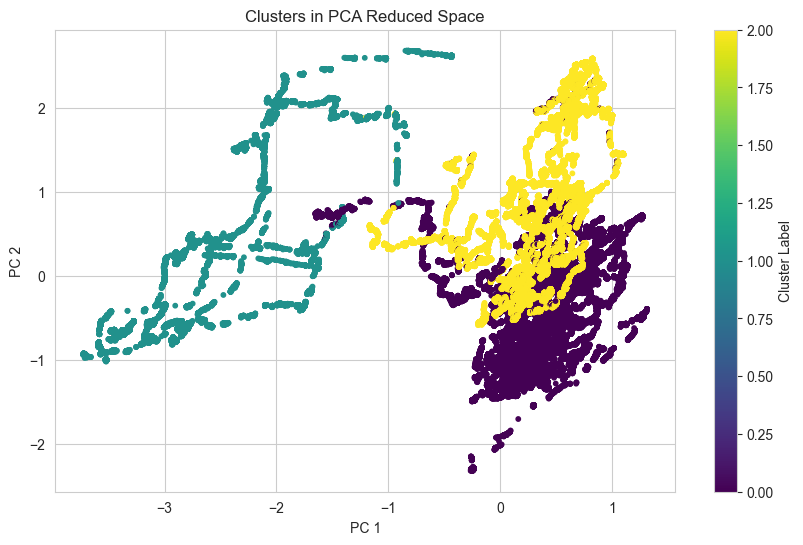

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(X_preprocessed[0], X_preprocessed[1], c=birch_clusters, cmap='viridis', s=10)
plt.title("Clusters in PCA Reduced Space")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='Cluster Label')
plt.show()

## GridSearch GMM + RandomForest

In [5]:
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from matplotlib.patches import Patch
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import joblib

X_preprocessed = pd.read_parquet('clean/X_preprocessed_train_3.parquet')
X_preprocessed.shape

(248687, 18)

In [7]:
# preprocessing = Pipeline([
#     ('robust_scaler', RobustScaler()),
#     ('minmax_scaler', MinMaxScaler()),
#     ('pca', PCA(n_components=0.95))
# ])

X_preprocessed = X_preprocessed[:30000]


gmm_param_grid = {
    'n_components': [3, 4, 7, 11],
    'covariance_type': ['full', 'tied', 'diag', 'spherical']
}

best_gmm = None
best_score = -np.inf
for params in [
    {'n_components': n, 'covariance_type': cov}
    for n in gmm_param_grid['n_components']
    for cov in gmm_param_grid['covariance_type']
]:
    gmm = GaussianMixture(**params, random_state=42)
    gmm.fit(X_preprocessed)
    labels = gmm.predict(X_preprocessed)

    if len(np.unique(labels)) < 2:  # skip degenerate solutions
        continue

    try:
        score = silhouette_score(X_preprocessed, labels)
    except:
        continue

    if score > best_score:
        best_score = score
        best_gmm = gmm
        best_labels = labels

print(f"Best GMM: {best_gmm}, Silhouette Score: {best_score:.4f}")

labels_df = pd.DataFrame(best_labels, columns=['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, best_labels, test_size=0.2, random_state=42, stratify=best_labels
)
train_size = int(len(X_preprocessed) * 0.8)

X_train = X_preprocessed.iloc[:train_size]
X_test = X_preprocessed.iloc[train_size:]
y_train = labels_df.iloc[:train_size]
y_test = labels_df.iloc[train_size:]

print(f"X_train shape {X_train.shape}", "X_test shape {X_test.shape}")

rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'rf__n_estimators': [10, 50, 70, 100],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=tscv, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print(f"Best RF Parameters: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

best_model = grid_search.best_estimator_
# joblib.dump(best_model, 'best_gmm_rf_model.pkl')

best_params = grid_search.best_params_
best_params_df = pd.DataFrame([best_params])
# best_params_df.to_csv('best_gmm_rf_params.csv', index=False)

Best GMM: GaussianMixture(covariance_type='diag', n_components=3, random_state=42), Silhouette Score: 0.3148
X_train shape (24000, 18) X_test shape {X_test.shape}


/Users/elena.leonova/PycharmProjects/hse_studying/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/elena.leonova/PycharmProjects/hse_studying/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/elena.leonova/PycharmProjects/hse_studying/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/elena.leonova/PycharmProjects/hse_studying/.venv/lib/python3.10

Best RF Parameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       718
           1       1.00      1.00      1.00      5282

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       718
           1       1.00      1.00      1.00      5282

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       754
           1       1.00      1.00      1.00      4618
           2       1.00      1.00      1.00       628

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



# Test Model

In [116]:
import numpy as np
import pandas as pd
import joblib
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# aligned_unscaled = pd.read_parquet('clean/prepared_with_features_2.parquet')
# aligned_unscaled.reset_index(drop=True, inplace=True)
#
# train_size = int(len(aligned_unscaled) * 0.8)
# train_df = aligned_unscaled.iloc[:train_size]
# test_df = aligned_unscaled.iloc[train_size:]
# train_df.shape, test_df.shape

X_preprocessed = pd.read_parquet('clean/X_preprocessed_train_3.parquet')
X_preprocessed_test = pd.read_parquet('clean/X_preprocessed_test_3.parquet')
X_preprocessed.shape, X_preprocessed_test.shape

((248687, 18), (62172, 18))

In [ ]:
# best_model = joblib.load('best_gmm_rf_model.pkl')

In [ ]:
preprocessing = Pipeline([
    ('robust', RobustScaler()),
    ('minmax', MinMaxScaler()),
    ('pca', PCA(n_components=0.95))
])

X_train = preprocessing.fit_transform(train_df)
X_test = preprocessing.transform(test_df)

gmm = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
gmm.fit(X_train)
y_train_clusters = gmm.predict(X_train)
y_test_clusters = gmm.predict(X_test)

rf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=42)
rf.fit(X_train, y_train_clusters)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)


# joblib.dump(gmm, 'models/final_gmm.pkl')
# joblib.dump(rf, 'models/final_rf.pkl')

def evaluate(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall (macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-Score (macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'Confusion Matrix': confusion_matrix(y_true, y_pred).tolist(),
        'Classification Report': classification_report(y_true, y_pred, output_dict=True)
    }


train_metrics = evaluate(y_train_clusters, y_pred_train)
test_metrics = evaluate(y_test_clusters, y_pred_test)

metrics_df = pd.DataFrame([train_metrics, test_metrics], index=['Train', 'Test'])
print("\nSummary:")
print(metrics_df[['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)']])

train_report = metrics_df.loc['Train', 'Classification Report']
test_report = metrics_df.loc['Test', 'Classification Report']
train_cm = metrics_df.loc['Train', 'Confusion Matrix']

In [18]:
preprocessing = Pipeline([
    ('robust', RobustScaler()),
    ('minmax', MinMaxScaler()),
    ('pca', PCA(n_components=0.95))
])

X_train = preprocessing.fit_transform(train_df)
X_test = preprocessing.transform(test_df)

gmm = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
gmm.fit(X_train)
y_train_clusters = gmm.predict(X_train)
y_test_clusters = gmm.predict(X_test)

rf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=42)
rf.fit(X_train, y_train_clusters)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# joblib.dump(gmm, 'models/final_gmm.pkl')
# joblib.dump(rf, 'models/final_rf.pkl')

def evaluate(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall (macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-Score (macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'Confusion Matrix': confusion_matrix(y_true, y_pred).tolist(),
        'Classification Report': classification_report(y_true, y_pred, output_dict=True)
    }

train_metrics = evaluate(y_train_clusters, y_pred_train)
test_metrics = evaluate(y_test_clusters, y_pred_test)

metrics_df = pd.DataFrame([train_metrics, test_metrics], index=['Train', 'Test'])
print("\nSummary:")
print(metrics_df[['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)']])

train_report = metrics_df.loc['Train', 'Classification Report']
test_report = metrics_df.loc['Test', 'Classification Report']
train_cm = metrics_df.loc['Train', 'Confusion Matrix']
test_cm = metrics_df.loc['Test', 'Confusion Matrix']


Summary:
       Accuracy  Precision (macro)  Recall (macro)  F1-Score (macro)
Train  1.000000           1.000000         1.00000          1.000000
Test   0.926977           0.950958         0.93514          0.941143


In [25]:
# pd.DataFrame(y_pred_train).to_csv('clean/y_pred_train.csv')
# pd.DataFrame(y_pred_test).to_csv('clean/y_pred_test.csv')

In [19]:
# metrics_df.to_csv('reports/final_train_test_metrics.csv')
metrics_df

,Accuracy,Precision (macro),Recall (macro),F1-Score (macro),Confusion Matrix,Classification Report
Train,1.000000,1.000000,1.00000,1.000000,"[[31957, 0, 0], [0, 91272, 0], [0, 0, 125458]]","{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc..."
Test,0.926977,0.950958,0.93514,0.941143,"[[6982, 0, 6], [0, 18201, 3668], [0, 866, 32449]]","{'0': {'precision': 1.0, 'recall': 0.999141385..."


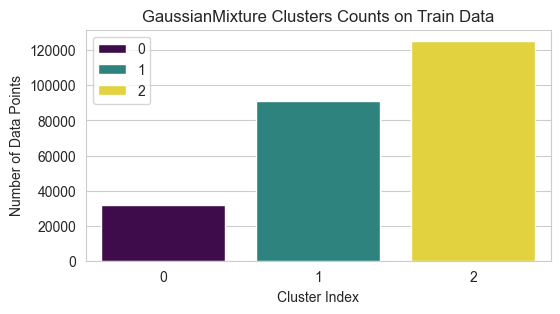

In [20]:
plot_cluster_counts(y_pred_train, "GaussianMixture Clusters", "on Train Data")

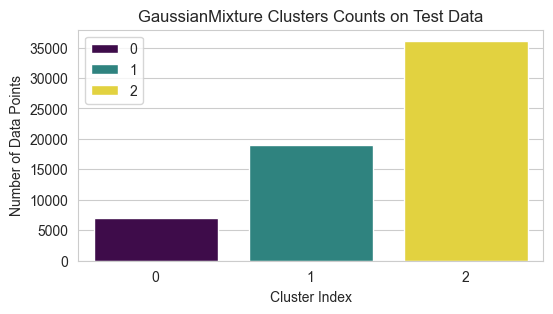

In [21]:
plot_cluster_counts(y_pred_test, "GaussianMixture Clusters", "on Test Data")

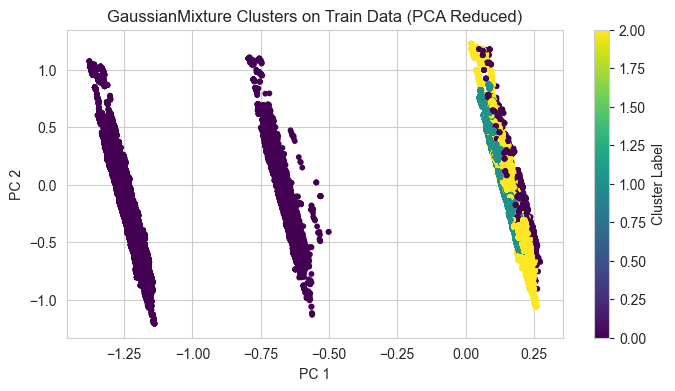

In [79]:
plot_scatter_clusters(X=X_train.T, labels=y_pred_train, title="GaussianMixture Clusters on Train Data")

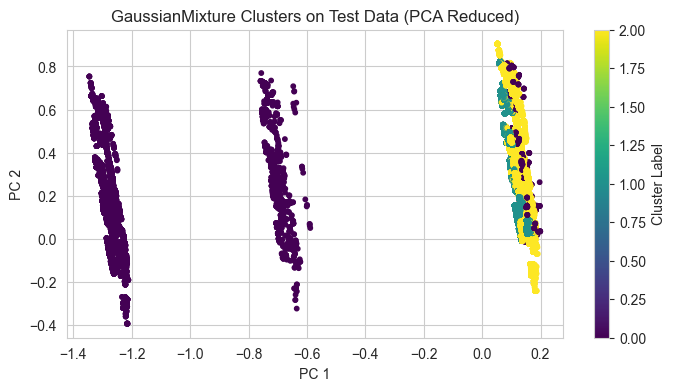

In [80]:
plot_scatter_clusters(X_test.T, y_pred_test, "GaussianMixture Clusters on Test Data")

## Compare Anomaly Scores and Clusters

In [ ]:
aligned_unscaled = pd.read_parquet('clean/prepared_with_features_2.parquet')
aligned_unscaled.reset_index(drop=True, inplace=True)

train_size = int(len(aligned_unscaled) * 0.8)
train_df = aligned_unscaled.iloc[:train_size]
test_df = aligned_unscaled.iloc[train_size:].reset_index(drop=True)

y_pred_train = pd.read_csv('clean/y_pred_train.csv').drop(columns=['Unnamed: 0'], axis=1)
y_pred_test = pd.read_csv('clean/y_pred_test.csv').drop(columns=['Unnamed: 0'], axis=1)

train_df['cluster_gmm'] = y_pred_train['0']
test_df['cluster_gmm'] = y_pred_test['0']
# test_df.loc[test_df[:], 'cluster_gmm'] = y_pred_train['0']
train_df.shape, test_df.shape

### Isolation Forest

In [56]:
preprocessing = Pipeline([
    ('robust', RobustScaler()),
    ('minmax', MinMaxScaler()),
    ('pca', PCA(n_components=0.95))
])

X_train = preprocessing.fit_transform(train_df)
X_test = preprocessing.transform(test_df)

In [61]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)
iso_forest.fit(X_train)
pred_labels = iso_forest.predict(X_train)  # -1 = anomaly, 1 = normal
scores = iso_forest.decision_function(X_train)

new_preds = iso_forest.predict(X_test)
new_scores = iso_forest.decision_function(X_test)

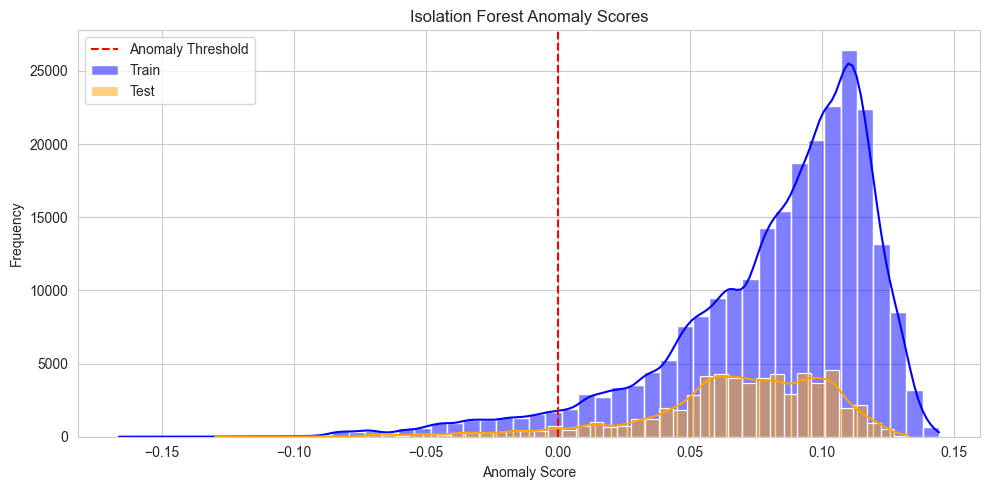

In [62]:
plt.figure(figsize=(10, 5))
sns.histplot(scores, bins=50, color='blue', label='Train', kde=True)
sns.histplot(new_scores, bins=50, color='orange', label='Test', kde=True)
plt.axvline(0, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
train_df['anomaly_score'] = scores
train_df['is_anomaly'] = pred_labels
test_df['anomaly_score'] = new_scores
test_df['is_anomaly'] = new_preds

train_df.shape, test_df.shape

In [ ]:
# train_df.to_parquet('clean/train_df_with_gmm&anomaly_score.parquet')
# test_df.to_parquet('clean/test_df_with_gmm&anomaly_score.parquet')

### Scores and Clusters

In [25]:
train_df_enrinched = pd.read_parquet('clean/train_df_with_gmm&anomaly_score.parquet')
test_df_enrinched = pd.read_parquet('clean/test_df_with_gmm&anomaly_score.parquet')

In [13]:
cluster_counts = train_df_enrinched['cluster_gmm'].value_counts()  # .reset_index().sort_values(by='cluster_gmm', ascending=True)
cluster_counts

cluster_gmm
2    125458
1     91272
0     31957
Name: count, dtype: int64

In [14]:
anomaly_counts = train_df_enrinched[train_df_enrinched['anomaly_score'] < 0].groupby('cluster_gmm')['anomaly_score'].count()  # .reset_index().sort_values(by='cluster_gmm', ascending=True)
anomaly_counts

cluster_gmm
0    6757
1     228
2    5450
Name: anomaly_score, dtype: int64

In [15]:
cluster_counts

cluster_gmm
2    125458
1     91272
0     31957
Name: count, dtype: int64

In [17]:
anomaly_cluster_percentage = pd.DataFrame(anomaly_counts / cluster_counts * 100).round(2).rename(columns={0: 'anomaly_percentage'})
anomaly_cluster_percentage

,anomaly_percentage
cluster_gmm,
0,21.14
1,0.25
2,4.34


In [18]:
train_df_enrinched['is_anomaly'].value_counts()

is_anomaly
 1    236252
-1     12435
Name: count, dtype: int64

In [19]:
train_df_enrinched[train_df_enrinched['anomaly_score'] < 0]['anomaly_score'].count()

np.int64(12435)

### Anomaly Periods

In [42]:
train_df_enriched = pd.read_parquet('clean/train_df_with_gmm&anomaly_score.parquet')
test_df_enriched = pd.read_parquet('clean/test_df_with_gmm&anomaly_score.parquet')
test_df_enriched.shape, test_df_enriched.shape

((62172, 103), (62172, 103))

In [43]:
prepared_df = pd.read_csv('clean/prepared_df.csv')
train_size = int(len(prepared_df) * 0.8)
prepared_df.shape, train_size

((310860, 77), 248688)

In [44]:
train_df_enriched['query_ts'] = prepared_df[:train_size]['query_ts']
train_df_enriched.shape

(248687, 104)

In [ ]:
plt.figure(figsize=(15, 3))
plt.plot(train_df_enrinched['query_ts'], [1]*len(train_df_enriched), 'k.', alpha=0.5)

anomalies = train_df_enrinched[train_df_enriched['is_anomaly'] == 1]
for ts in anomalies['query_ts']:
    plt.axvline(ts, color='red', alpha=0.3)

plt.title('Timestamps with Anomalies Highlighted')
plt.xlabel('Timestamp')
plt.yticks([])
plt.tight_layout()
plt.show();